# TODO



3. Add more checkpoint

4. use TSNE detect outlier
   - analyze why anomaly point happen

5. Optimize model and hyperparameter
   - show accuracy
   - analyze training data



7. Use tensorflow serving/tensorflow deployment

8. use Tensorboard to analyze training process



# Network Traffic Prediction with LSTM
In this notebook, we'll build a LSTM model for a standard time series forecasting problem based on the bluemix network traffic data. Then we'll use the model to predict the future network traffic. The notebook contains the following sections:

- Problem Description
- Environment Preparation
- Load Network Traffic Data to Notebook
- Data Preparation
- Analyze Data
- Anomaly Detection
- Save data 
- Build Multi-step LSTM Model
- Build One-step LSTM Model
- Save Model
- Load Model in production
- Conclusion

## Problem Description

The problem that we'll work on is the network traffic prediction problem for Bluemix platform. By using the Bluemix network data (received & transferred) collected within a 2-month period, we shall build a LSTM model to predict the future network trend.

## Environment Preparation

Before we start working on the data, we need to import the following packages to set up the environment. We will be using the **Keras** open source neural network library, running on top of **Tensorflow**, to implement the LSTM model.

In [1]:
import numpy as np
import matplotlib as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dropout, Activation
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## Load Network Traffic Data from Swift Object Storage

Now we can load the Bluemix network traffic data to this notebook. The data were provided via 6 CSV files, which we have uploaded to DSX. Thus, the data files are now stored in Bluemix object storage.

### Setup Username/Password of Swift 

Since we'll later publish this notebook to a public Github, we need to set the object storage credentials in a hidden cell to avoid the leaking of account information.  

In [2]:
# The code was removed by DSX for sharing.

###  Define the load_file Function

In [3]:
from io import StringIO
import requests
import json
import pandas as pd
def load_file(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': name,'domain': {'id':domain_id },
            'password': password}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)


### List CSV Files used for Training
There are six CSV files stored in object storage, which will be used for training and testing.

In [4]:
data_files=['env5_brain_192.155.247.207_20170401_20170601.csv',
            'env5_brain_169.55.245.30_20170401_20170601.csv',
            'env5_brain_169.54.213.198_20170401_20170601.csv',
            'env5_brain_10.143.131.55_20170401_20170601.csv',
            'env5_brain_10.143.123.125_20170401_20170601.csv',
            'env5_brain_10.107.77.247_20170401_20170601.csv']


### Load CSV Files to memory
We'll load the 6 CSV files to memory by using the ``load_file`` function defined above. The data is loaded as Pandas dataframe.

In [5]:
dataframes=[]
for data_file in data_files:
    dataframes.append(pd.read_csv(load_file(container, data_file)))


## Data Preparation
As we have now loadded the CSV files to this notebook, we need to analyze the datasets to prepare the data for modelling. The 6 CSV files represent the received and transferred network flow of 6 Bluemix nodes, accross the same time period of about 60 days. The **timestamp** colume in the CSV files indicates the time when the network data was collected, while each timestamp is separated by the same interval of 5 minutes. 

Since the 6 Bluemix nodes come from the same cluster and share workload within the cluster, we will merge the network traffic data in the 6 CSV files to form a new dataset for modelling. To do this, we first need to retrieve the timestamp series as we will merge the network data with the same timestamp. 

Moreover, as the 5 minute intervals are a bit too small for detecting the network traffic patterns, we will accumulate the data to present the network traffic of each hour.

Once done, we will also need to normalize the dataset by rescaling the data values to the range of 0-to-1, which is a good practice for using the LSTM model.

In conclusion, for this section, we will prepare the data with the following steps:
 - Retrieve Timestamp Series
 - Merge Six Datasets into One 
 - Compute Hourly Network Traffic
 - Normalize Dataset

### Retrieve Timestamp Series
Retrieve all timestamps in data files. 

In [6]:
timestamps=set()
for data in dataframes:
    for t in (data['timestamp']):
        timestamps.add(t)

ts=sorted(timestamps)

ts_2_idx={}
idx_2_ts={}
idx=0
for timestamp in ts:
    ts_2_idx[timestamp]=idx
    idx_2_ts[idx]=timestamp
    idx+=1

### Merge Six Datasets into One 
Since all 6 nodes are in the same cluster and only one node is under Active mode at one time, we merge all traffic from the 6 nodes according to the timestamp.

In [7]:
merged_input=np.empty(shape=(0,2))
for t in ts:
    sum_received=0
    sum_transferred=0
    for dataframe in dataframes:
        i=dataframe[dataframe['timestamp']==t]
        cur_received=i.get('net_received',0)
        cur_transfer=i.get('net_transferred',0)
        for ind in cur_transfer.index:
            sum_transferred+=cur_transfer[ind]
        for ind in cur_received.index:
            sum_received+=cur_received[ind]
    merged_input=np.append(merged_input,[[sum_received,sum_transferred]],axis=0)


#### Display net_received traffic graph  

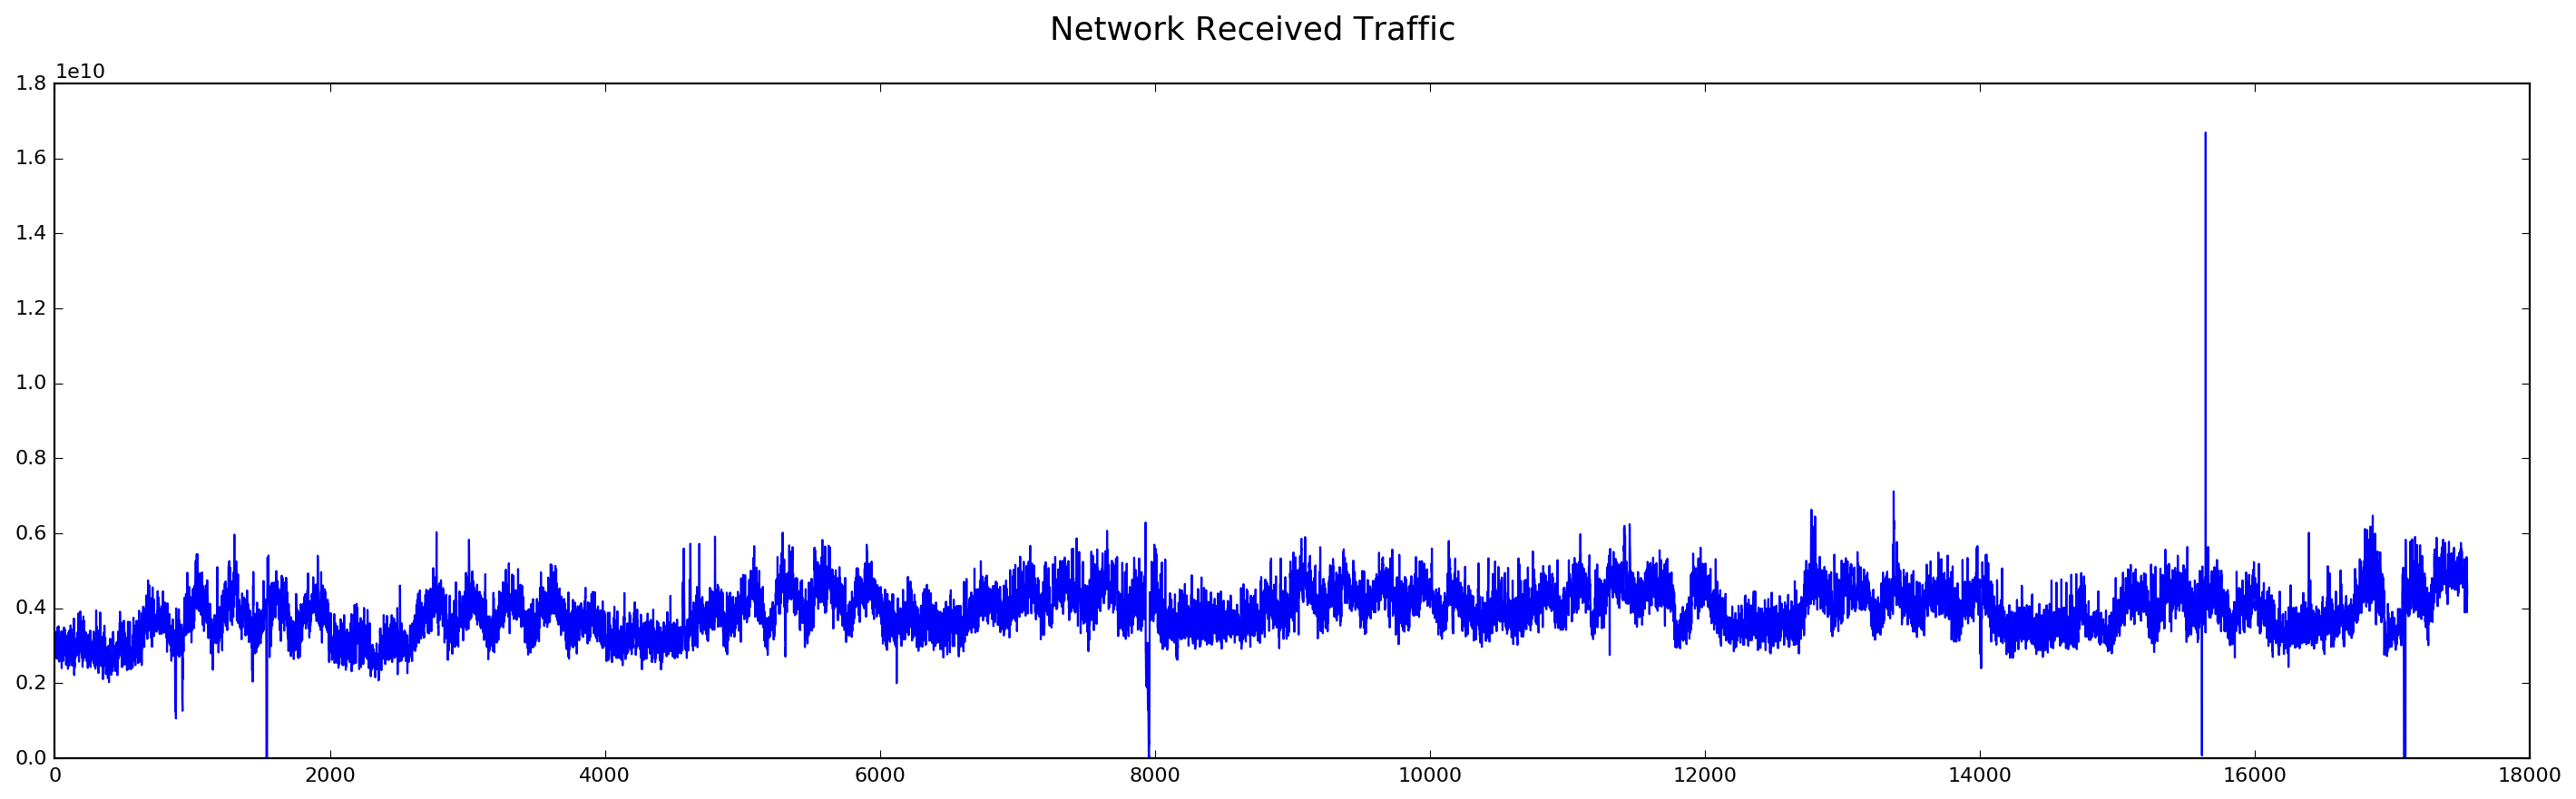

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22,6), dpi=80)
plt.suptitle('Network Received Traffic', fontsize=16)
plt.plot(merged_input[:,0:1])
plt.show()

#### Display net_trasferred traffic graph  

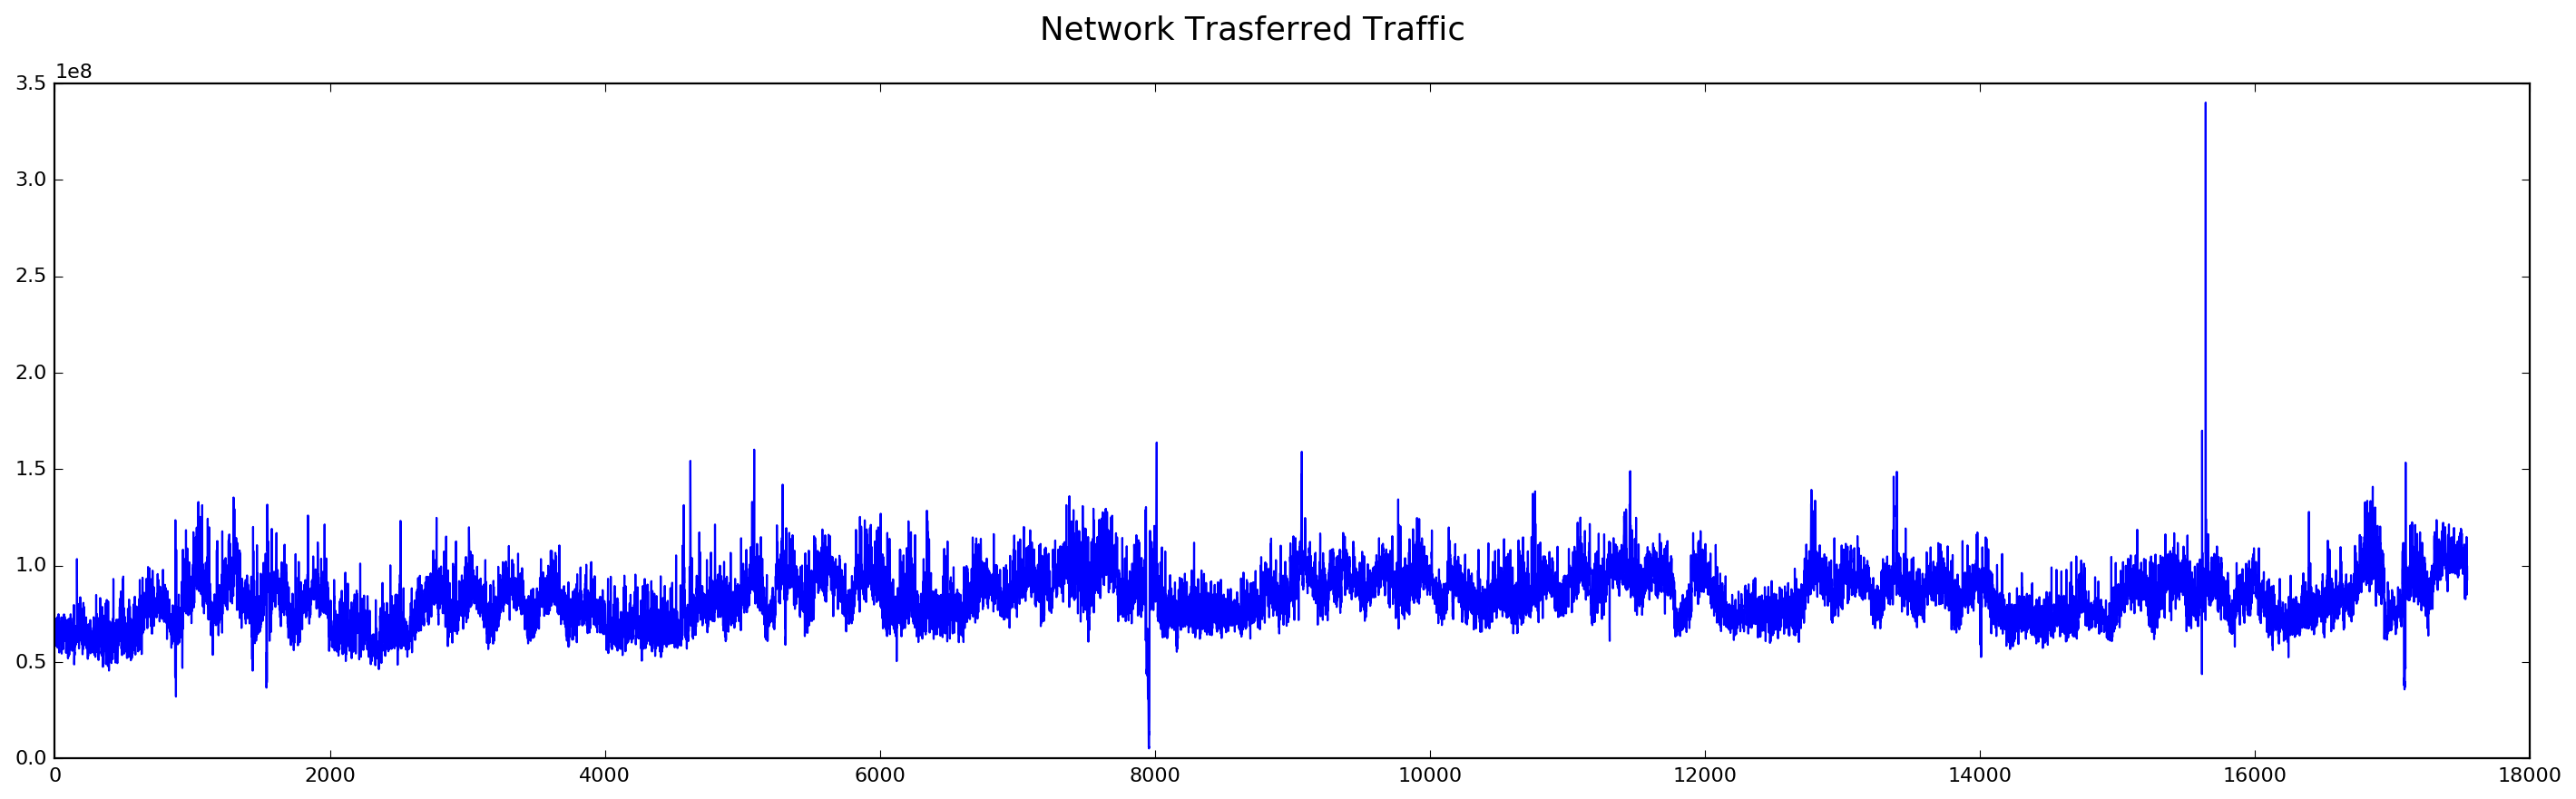

In [9]:
plt.figure(figsize=(22,6), dpi=80)
plt.suptitle('Network Trasferred Traffic', fontsize=16)
plt.plot(merged_input[:,1:2])
plt.show()

### Compute Hourly Network Traffic
The timestamps are recorded in 5min-intervals, which are a bit too small for capturing the network flow trends. Therefore, we accumulate the network traffic data on hourly bases. 

In [10]:
hourly_input=np.empty(shape=(0,2))
size=merged_input.shape[0]
for i in range(0,size,12):
    slice=merged_input[i:i+12,:]
    hourly_rev=0
    hourly_transfer=0
    for s in slice:
        hourly_rev+=s[0]
        hourly_transfer=s[1]
    hourly_input=np.append(hourly_input,[[hourly_rev,hourly_transfer]],axis=0)

#### Display hourly network traffic graph  

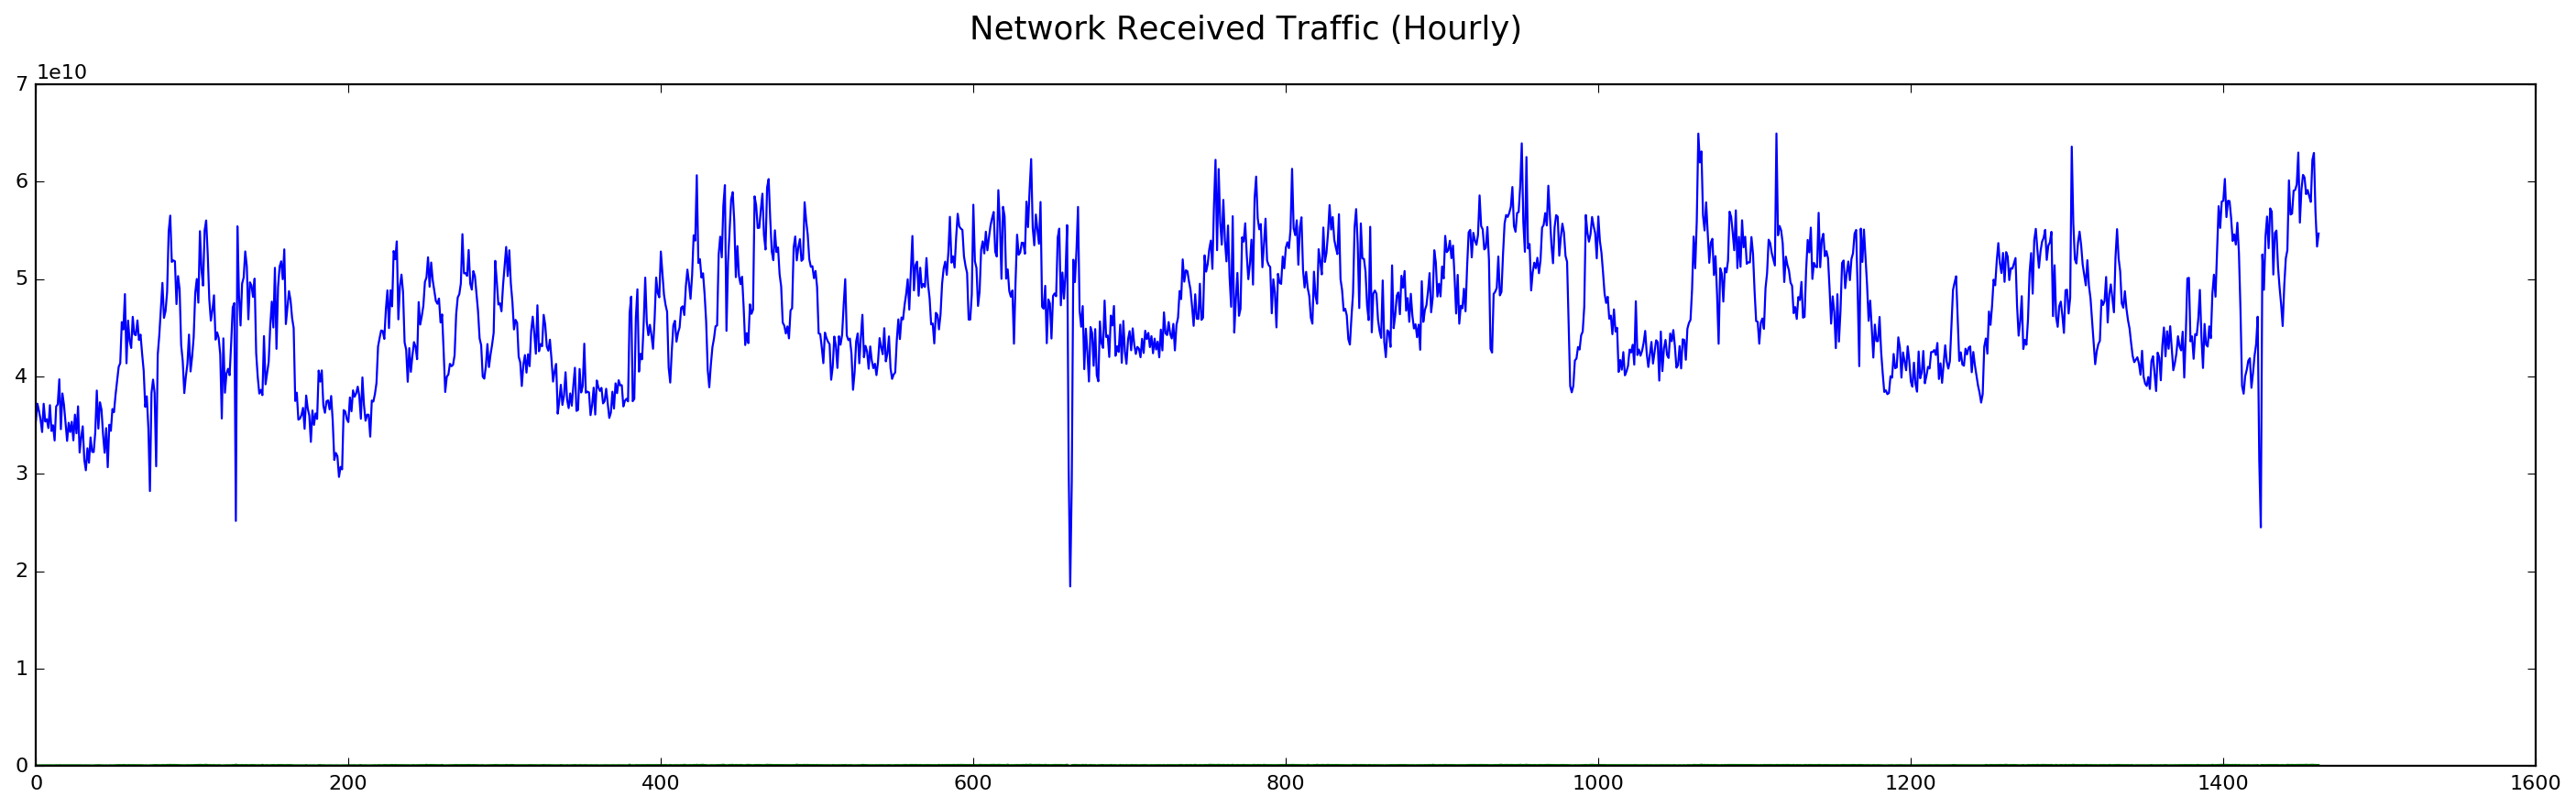

In [11]:
# net_received traffic flow
plt.figure(figsize=(22,6), dpi=80)
plt.suptitle('Network Received Traffic (Hourly)', fontsize=16)  
plt.plot(hourly_input)
plt.show()

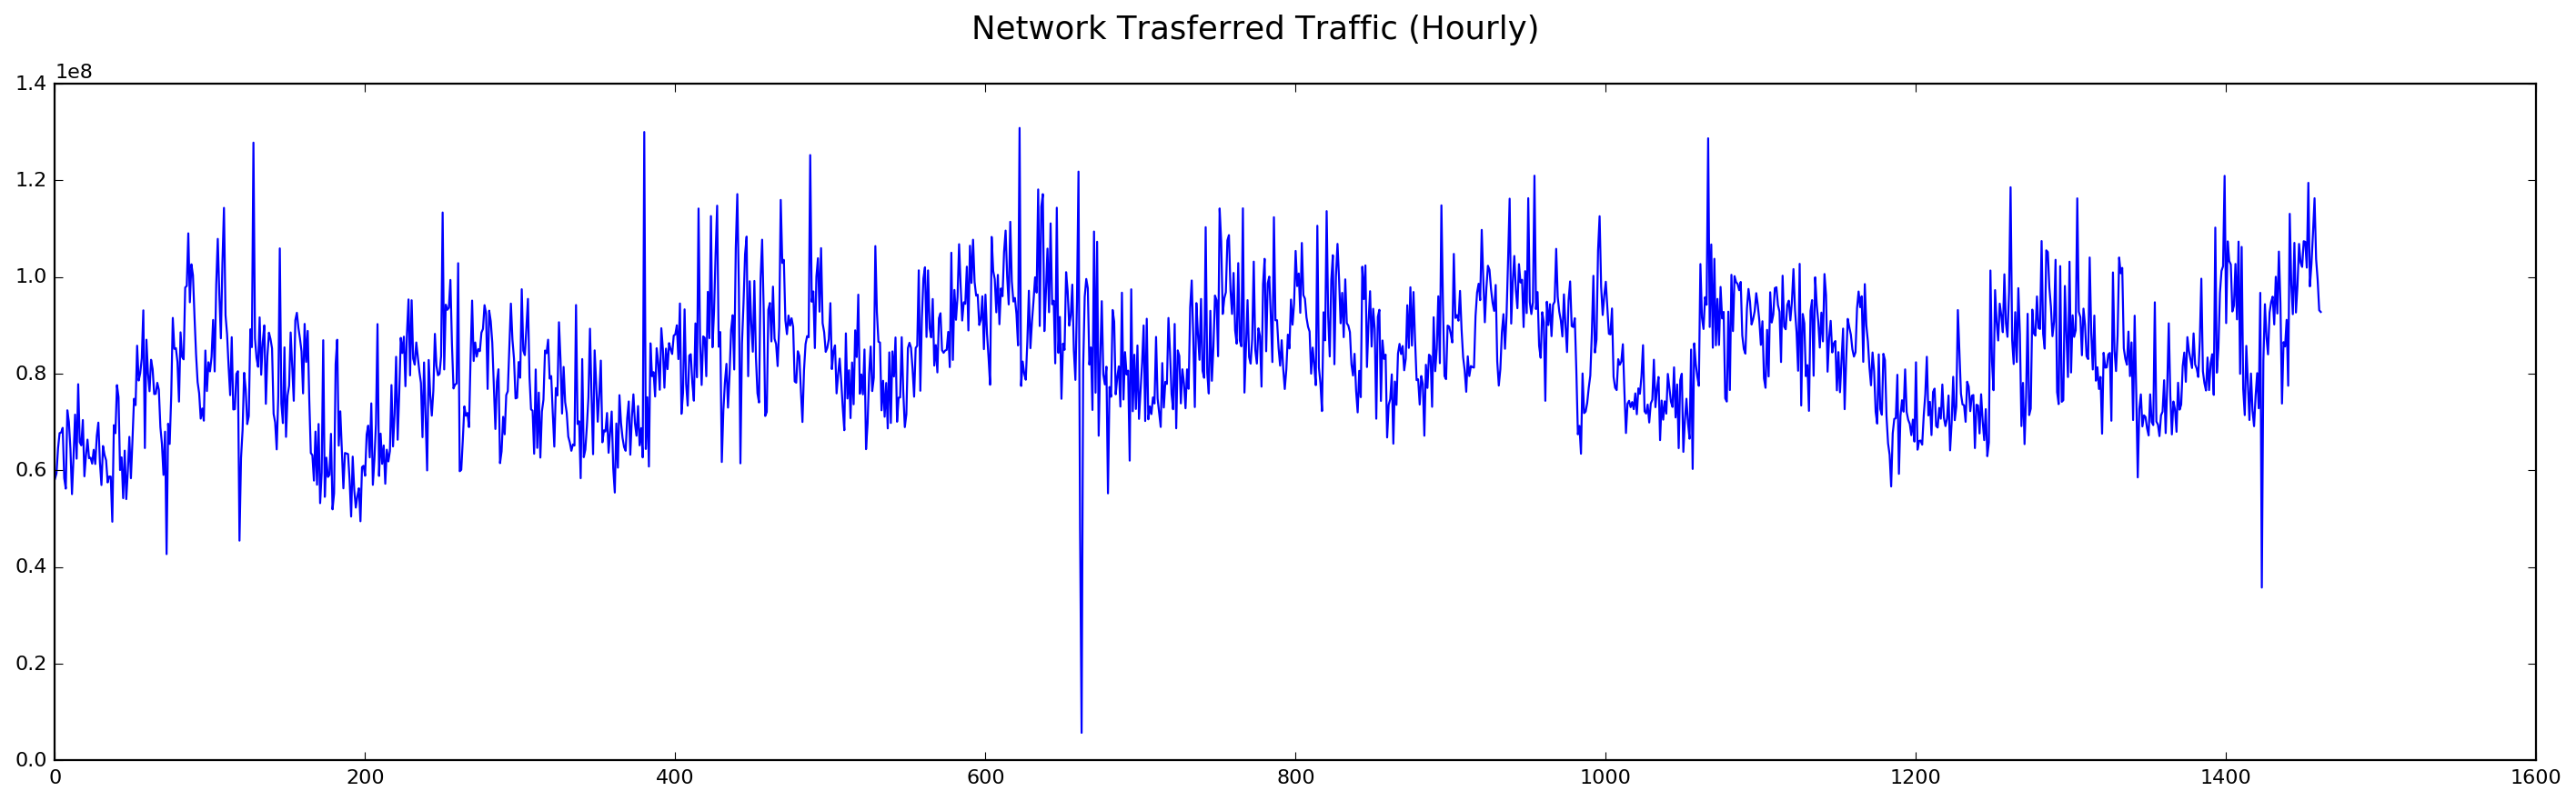

In [13]:
# net_trasferred traffic flow
plt.figure(figsize=(22,6), dpi=80)
plt.suptitle('Network Trasferred Traffic (Hourly)', fontsize=16) 
plt.plot(hourly_input[:,1:2])
plt.show()

### Normalize Dataset into (0,1) 
LSTM models are sensitive to the scale of the input data, which is why we will rescale the data to the range of 0-to-1, i.e. normalizing. 

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset_receive = scaler.fit_transform(hourly_input[:,0:1])

scaler2 = MinMaxScaler(feature_range=(0, 1))
dataset_transfer = scaler2.fit_transform(hourly_input[:,1:2])

#### Plot diagram after data normalization

Plot diagram for network traffic after data normalization. The recieved network traffic is plot in blue, while the transferred traffic is plot in green. We can see that both traffic data follow the same trend.

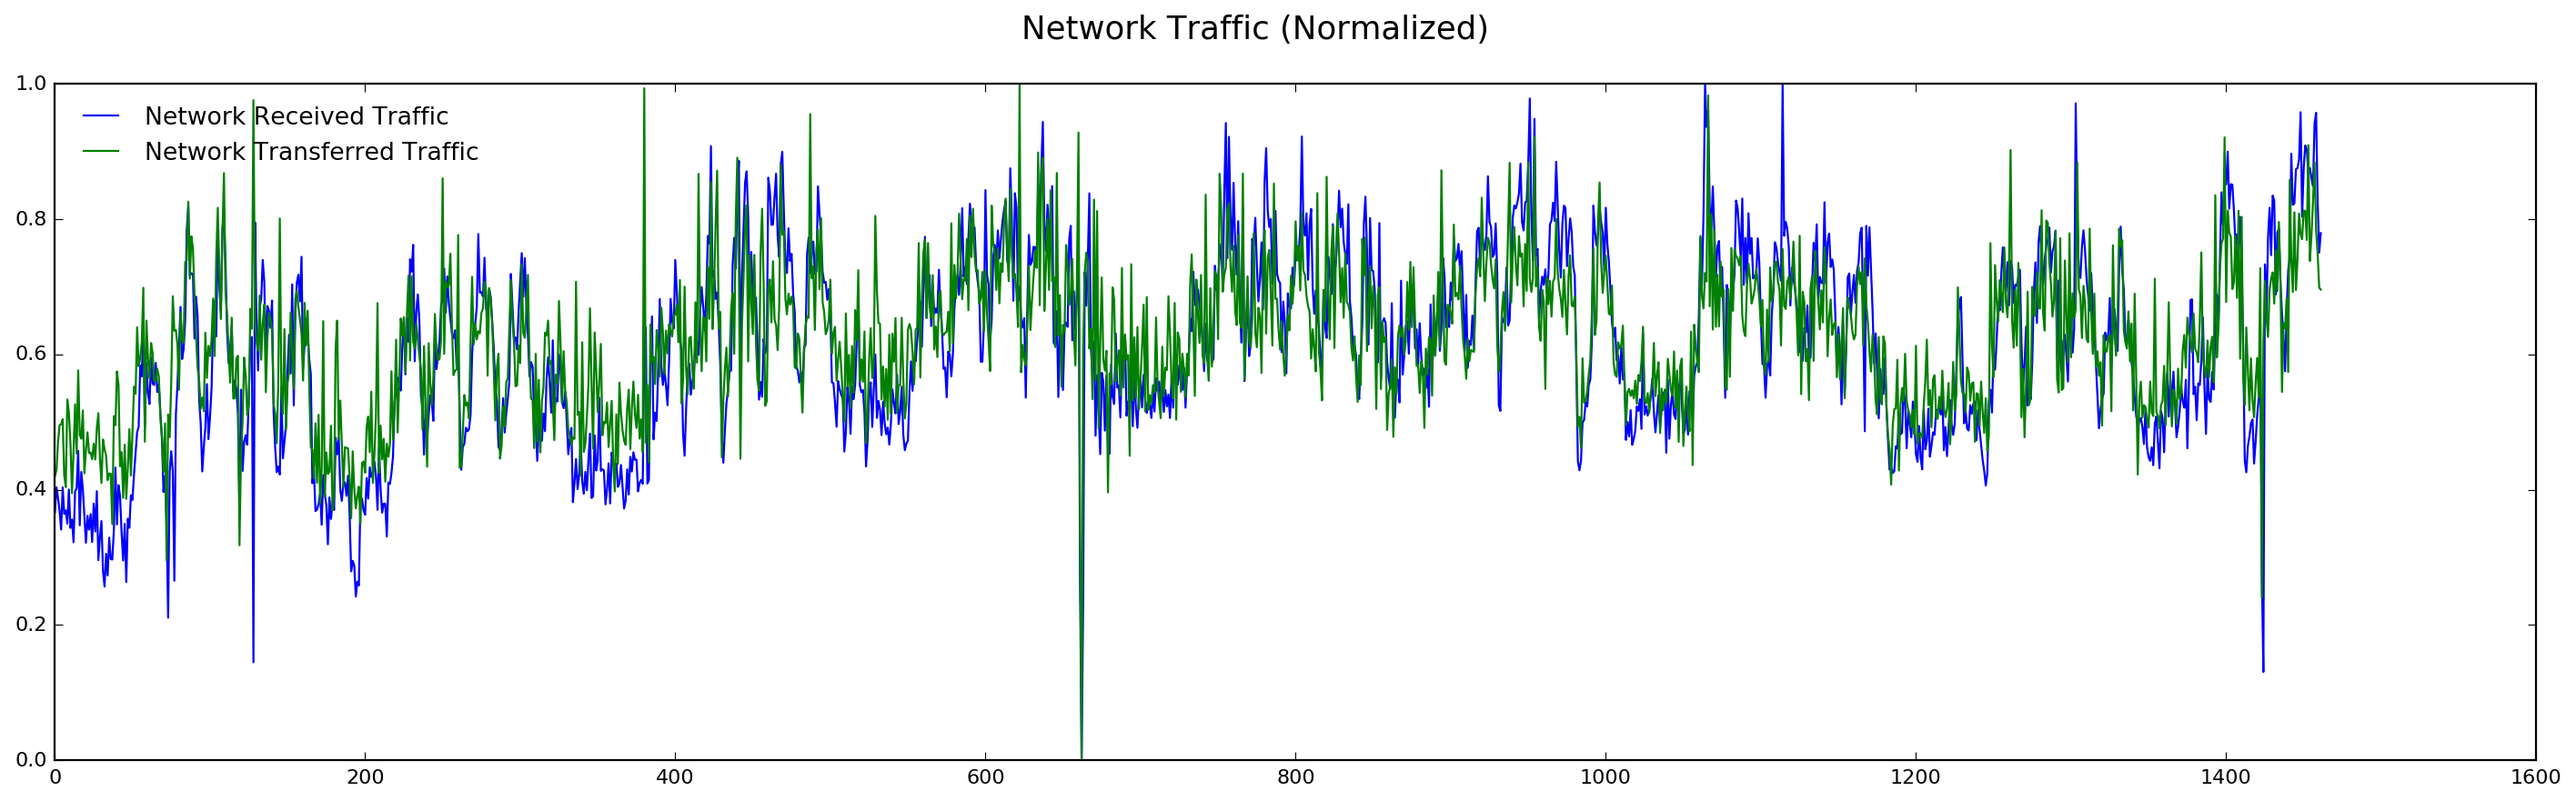

In [13]:
plt.figure(figsize=(22,6), dpi=80)
plt.suptitle('Network Traffic (Normalized)', fontsize=16) 
plt.plot(dataset_receive, color="blue", label="Network Received Traffic")
plt.plot(dataset_transfer, color="green" , label="Network Transferred Traffic")
plt.legend(loc='upper left', frameon=False)
plt.show()

## Analyze Data

Here we will analyze the network traffic data to see if there's any pattern to be traced. Thus, we have the following figure with vertical lines separating the data according to days (24 hours). The lines in green stand for weekends (Saturday and Sunday), orange for Mondays, and pink for other weekdays. The network received traffic is plot in blue, while the network transferred traffic is in green. 

In [14]:
import datetime

dtime = pd.Series()

for i in range(0,len(ts),12):
    d=datetime.datetime.fromtimestamp(ts[i])
    d1=pd.Series([d]) 
    dtime=dtime.append(d1)

dtime.reset_index(drop=True, inplace=True)

xdate = pd.Series()

for i in range(1,len(dtime),1):
    if dtime[i-1].date() < dtime[i].date(): 
        d2 = pd.Series([i])  
        xdate = xdate.append(d2)

xdate.reset_index(drop=True, inplace=True)


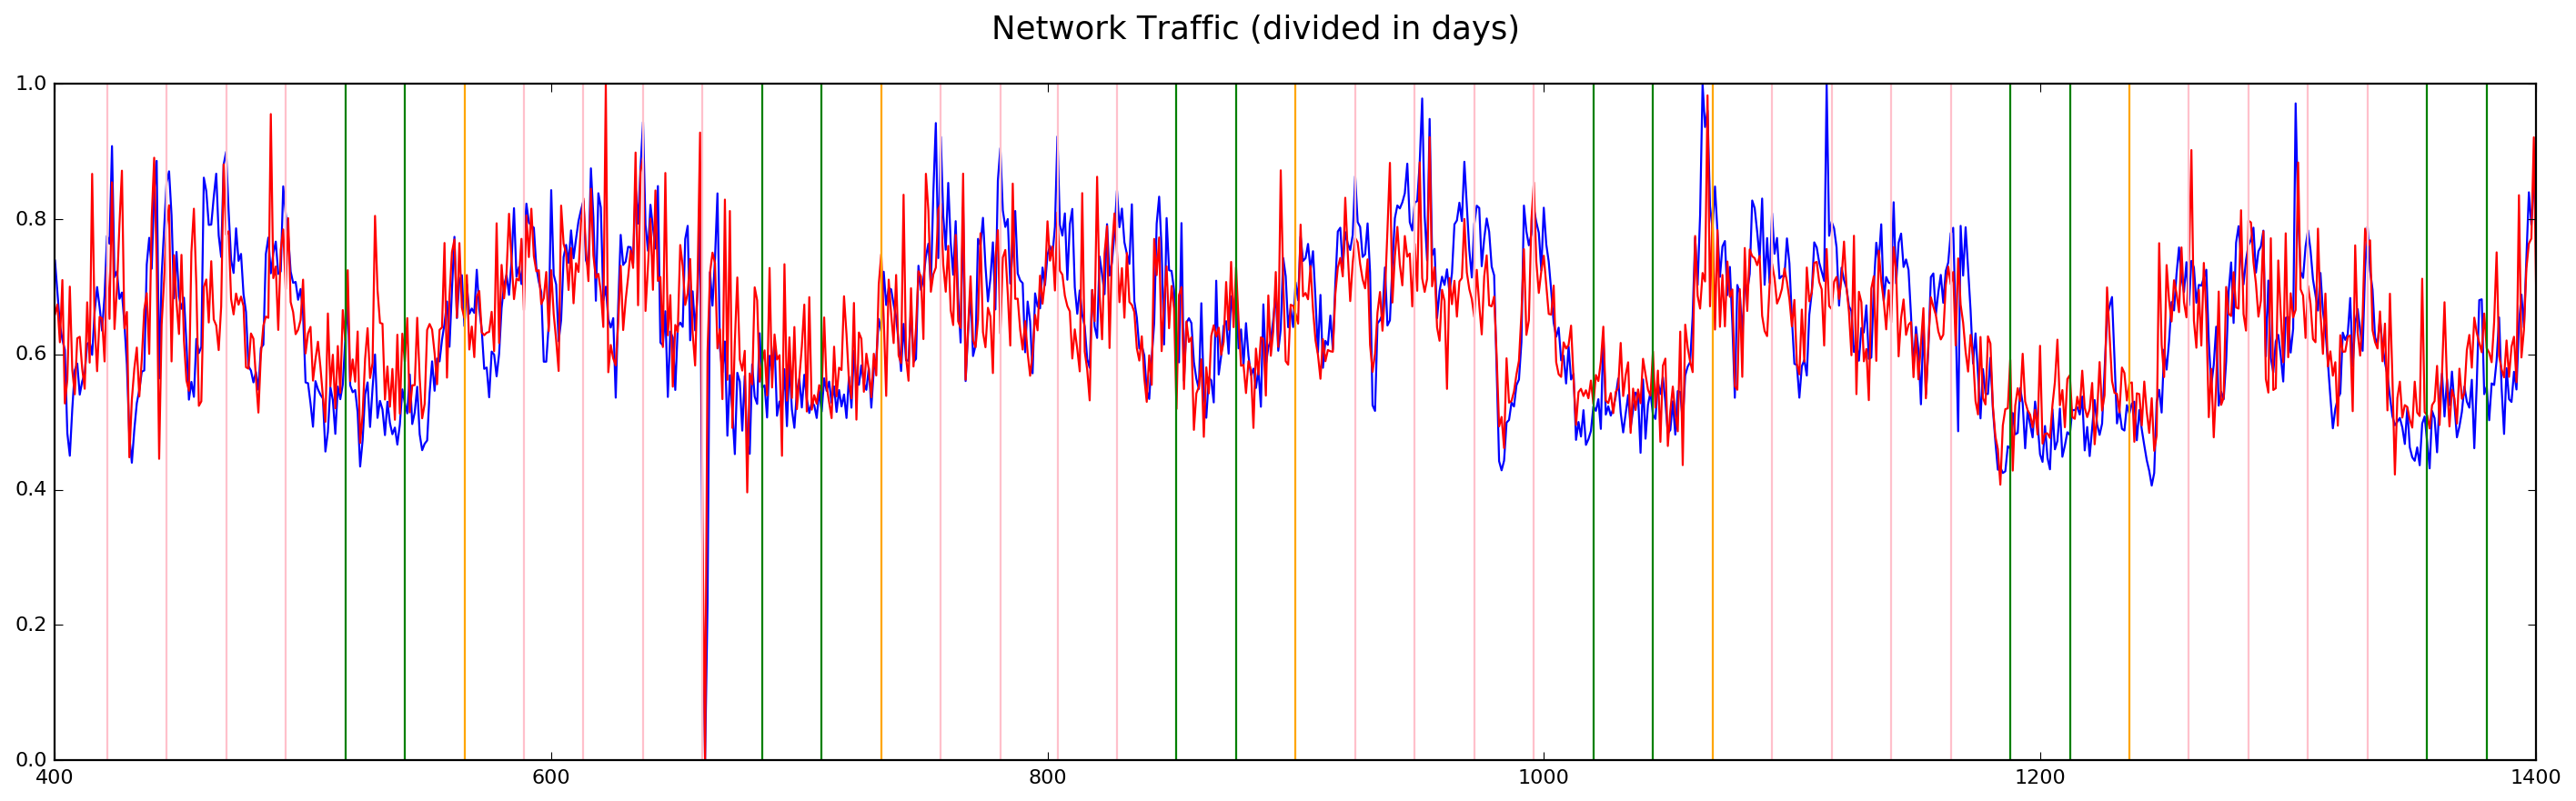

In [15]:
# Weekends (Sunday & Saturday) are plot in green
# Mondays are plot in orange
# Other workdays are in pink

plt.figure(figsize=(22,6), dpi=80)
plt.xlim(400,1400)
plt.suptitle('Network Traffic (divided in days)', fontsize=16) 
plt.plot(dataset_receive, color="blue")
plt.plot(dataset_transfer, color="red")
for i in range(len(xdate)):
    aa=xdate[i]
    if dtime[aa].date().weekday()== 0:
        plt.axvline(xdate[i], color = "orange")
    elif dtime[aa].date().weekday()>4:
        plt.axvline(xdate[i], color = "green")
    else:
        plt.axvline(xdate[i], color = "pink")
plt.show()

From the data analysis, we can see that the network traffic data represents unique trends within a week period, with relatively low traffic during weekends and high traffic during weekdays. Also, there's usually a drop in the traffic amount during the middle of the day, which makes sense as considering the time difference between US and China.

## Anomaly Detection
From the figures above, we can see that there are a few data points plotted far away from the major dataset, which should be treated as normality.

Thus, in this section, we will detect the abnormal data points and remove them from the dataset. To do this, we'll need to define a boundary around normal data points so that they can be distinguishable from outliers.

### Define Boundary 

Since most of the network traffic is distributed within an area of 0.4 to 0.9 (normalized), we'll use the Gaussian distribution to detect the abnormal data points, which should have quite low occurrence rates in the distribution.  

Here we use 2\*sigma to find the abnormal ponits outside the range of 95.46% (boundary) from a Gaussian distribution. In other words, we will only handle the most obvious outliners (less than 5% of occurrence) as the LSTM model should be able to detect the rest of the abnormal network traffic and "forget" them during memory update. 

The following are the figures of the Gaussian distribution of network received traffic and network transferred traffic respectively.

mu=[ 0.60971143]
sigma=0.0196175719393


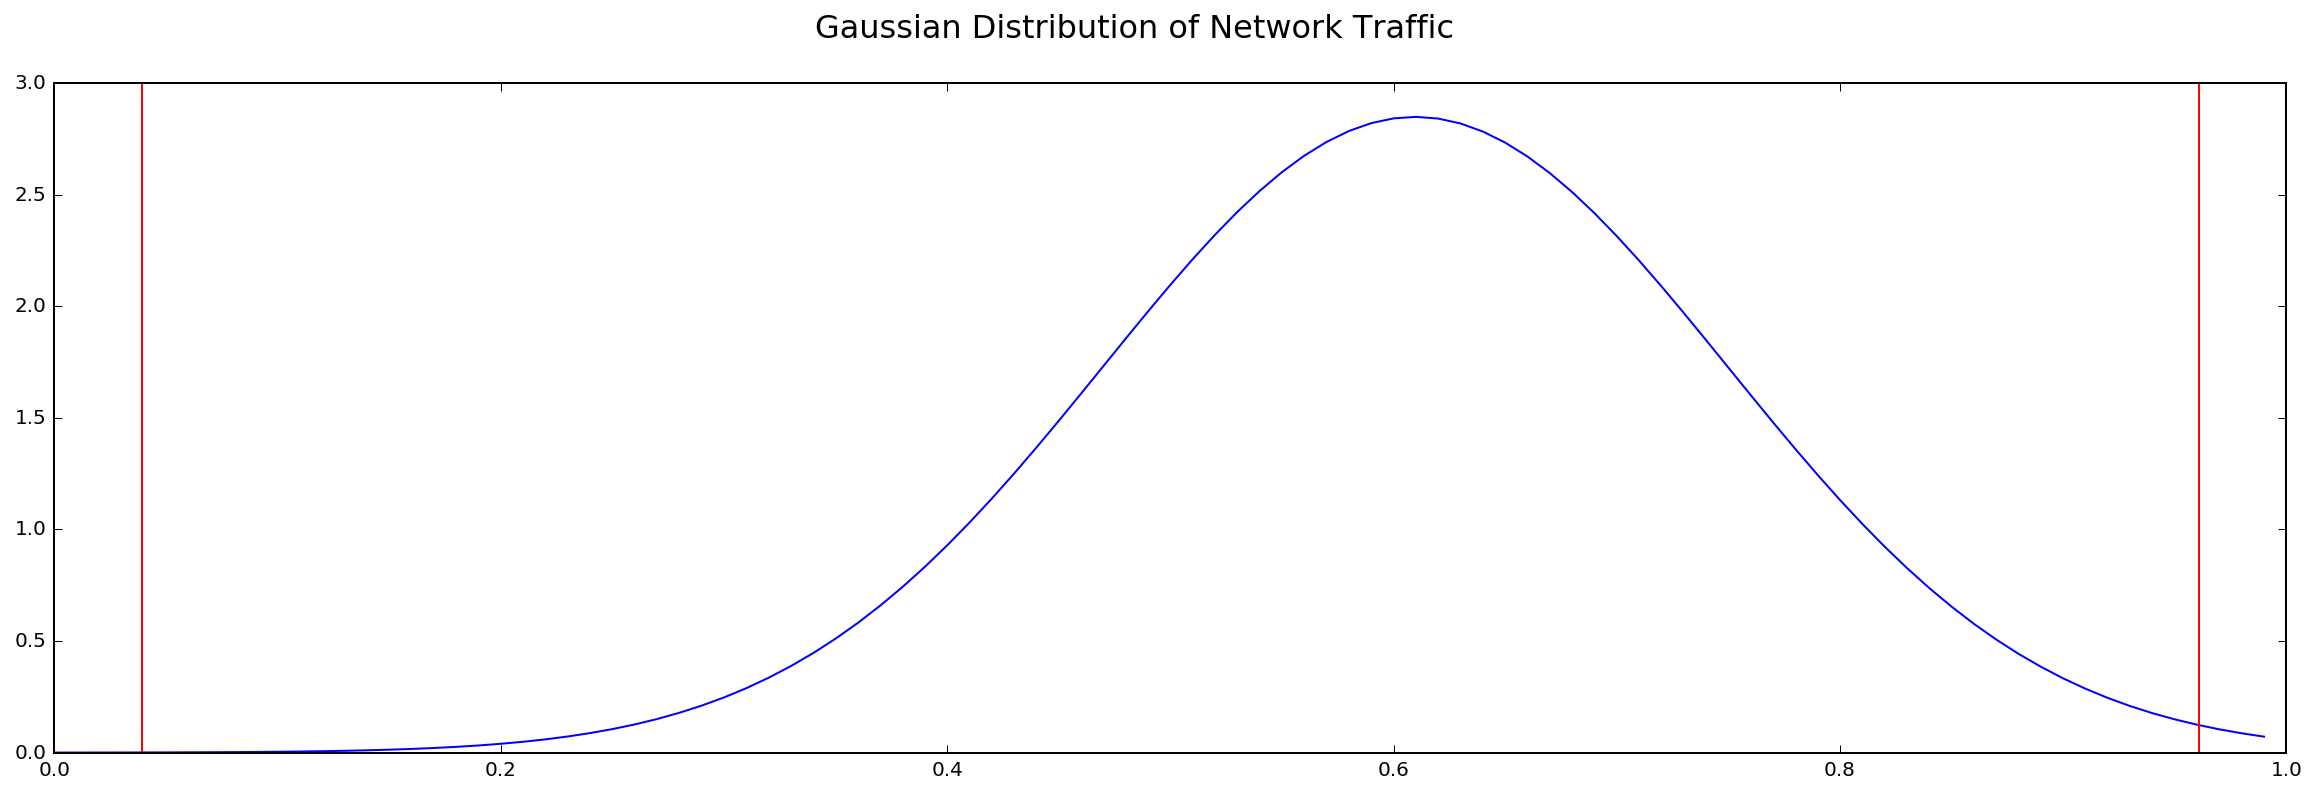

mu=[ 0.62041082]
sigma=0.0113498237086


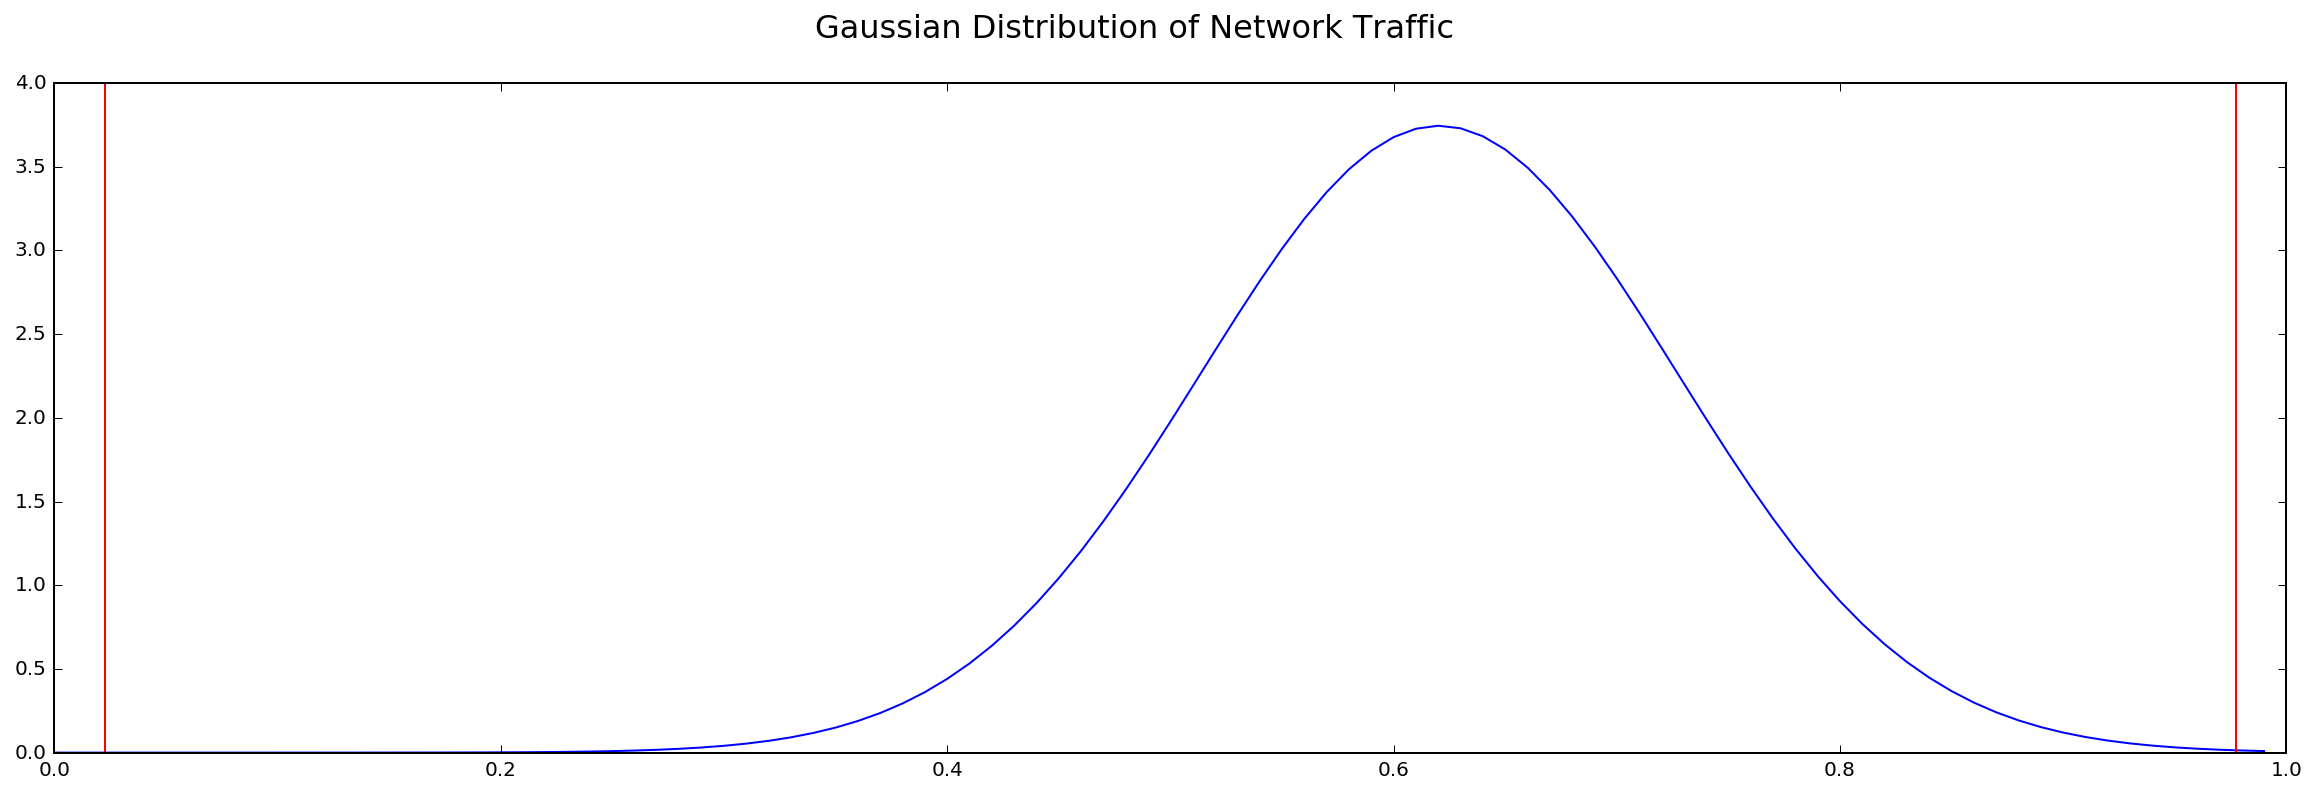

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
from scipy.stats import multivariate_normal

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma


def find_outline_boundary(dataset, title):
    array_data = np.asarray(dataset) 
    mu, sigma = estimateGaussian(array_data)
    print("mu=" + str(mu))
    print("sigma=" + str(sigma))
    
    outline1 = 2 * sigma
    outline2 = 1- (2* sigma)

    x1 = np.linspace(0, 1, 100, endpoint=False)
    y1 = multivariate_normal.pdf(x1, mean=mu, cov=sigma);
    
    plt.figure(figsize=(20,6))
    plt.suptitle(title, fontsize=16) 
    plt.plot(x1, y1)
    plt.axvline(x=outline1, color = "red")
    plt.axvline(x=outline2, color = "red")
    plt.show()
    return outline1, outline2

dataset_receive_outline1, dataset_receive_outline2 = find_outline_boundary(dataset_receive, "Gaussian Distribution of Network Received Traffic")
dataset_transfer_outline1, dataset_transfer_outline2 = find_outline_boundary(dataset_transfer, "Gaussian Distribution of Network Transferred Traffic")

### Adjust Abnormal Points

Now that we have the boundaries defined, dividing the abnormal data points from the normal newtork data, we shall adjust the abnormal data so that they could land in the normal data range.

The following are the figures of listing the outliers of network received traffic and network transferred traffic respectively.

0     662
1     951
2    1064
3    1114
4    1303
dtype: int64
0    0.000000
1    0.978205
2    0.999834
3    1.000000
4    0.970987
dtype: float64


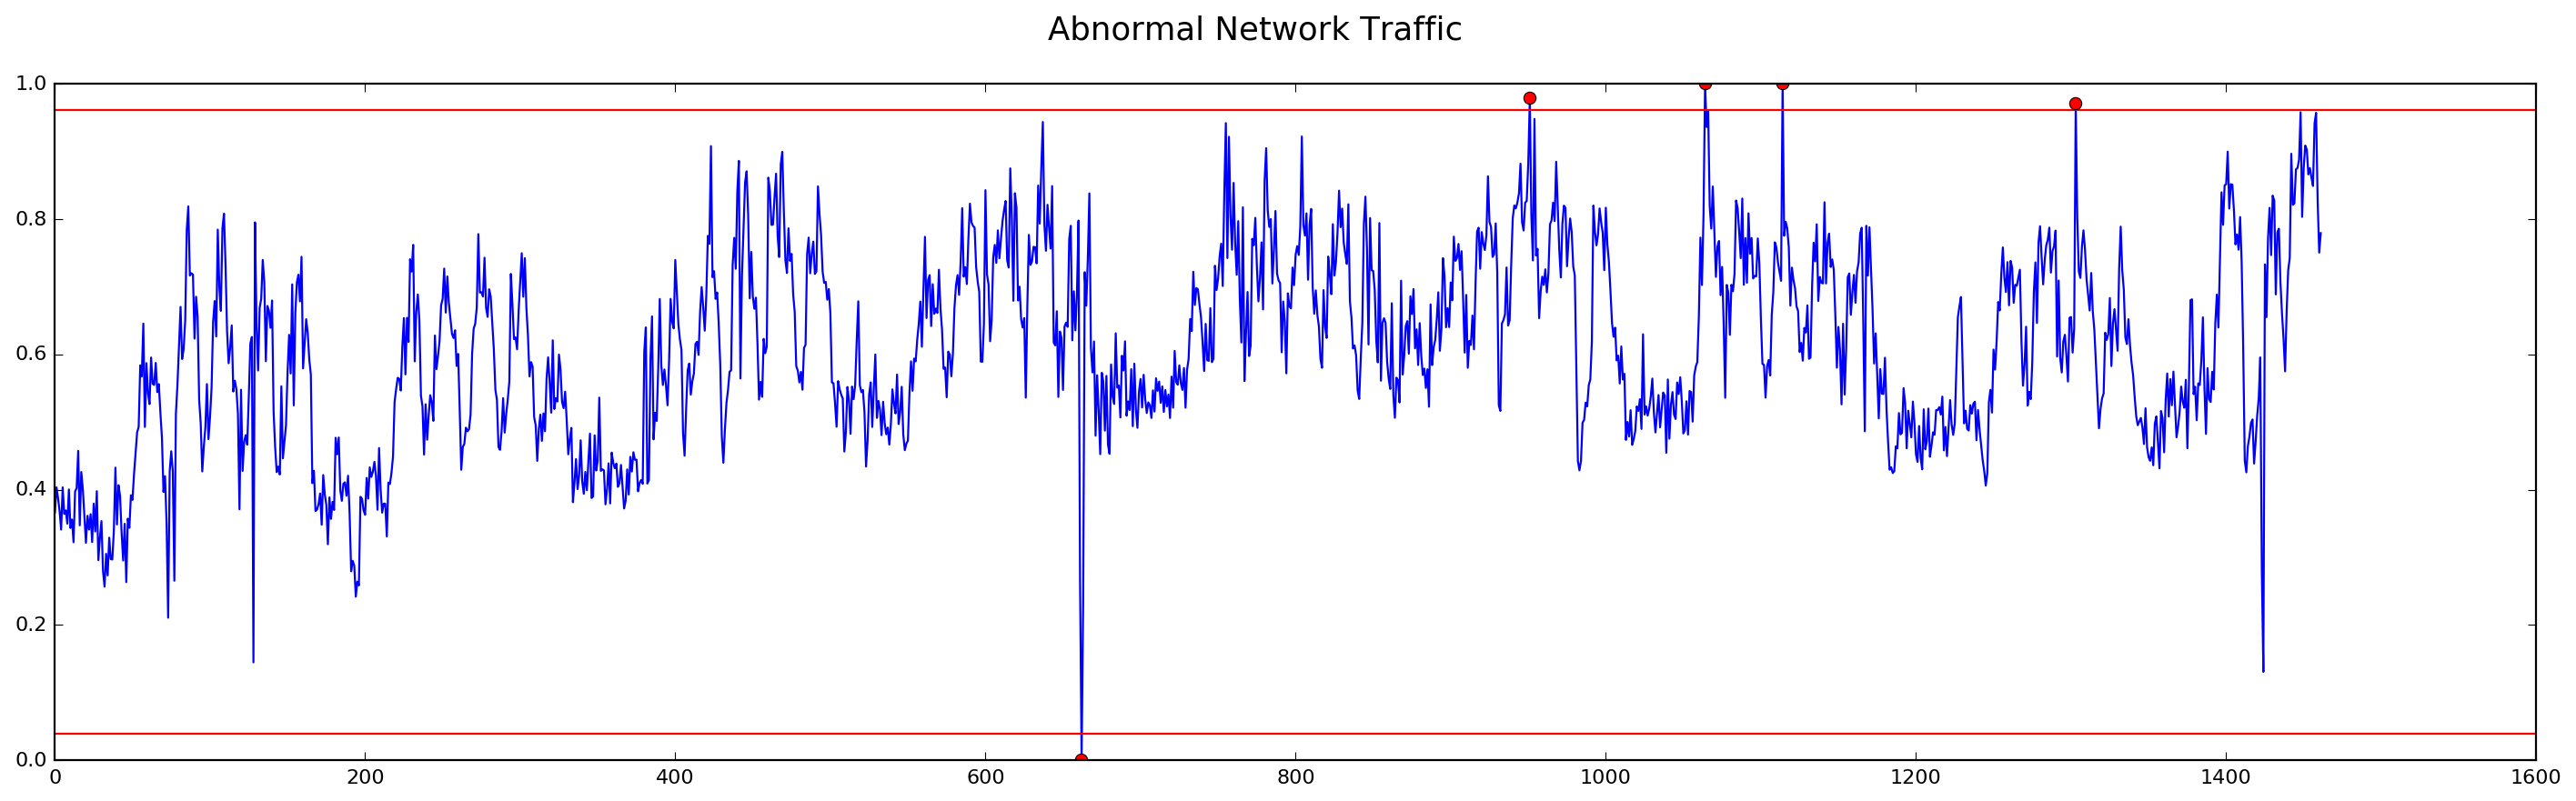

0     380
1     622
2     662
3    1066
dtype: int64
0    0.993281
1    1.000000
2    0.000000
3    0.982871
dtype: float64


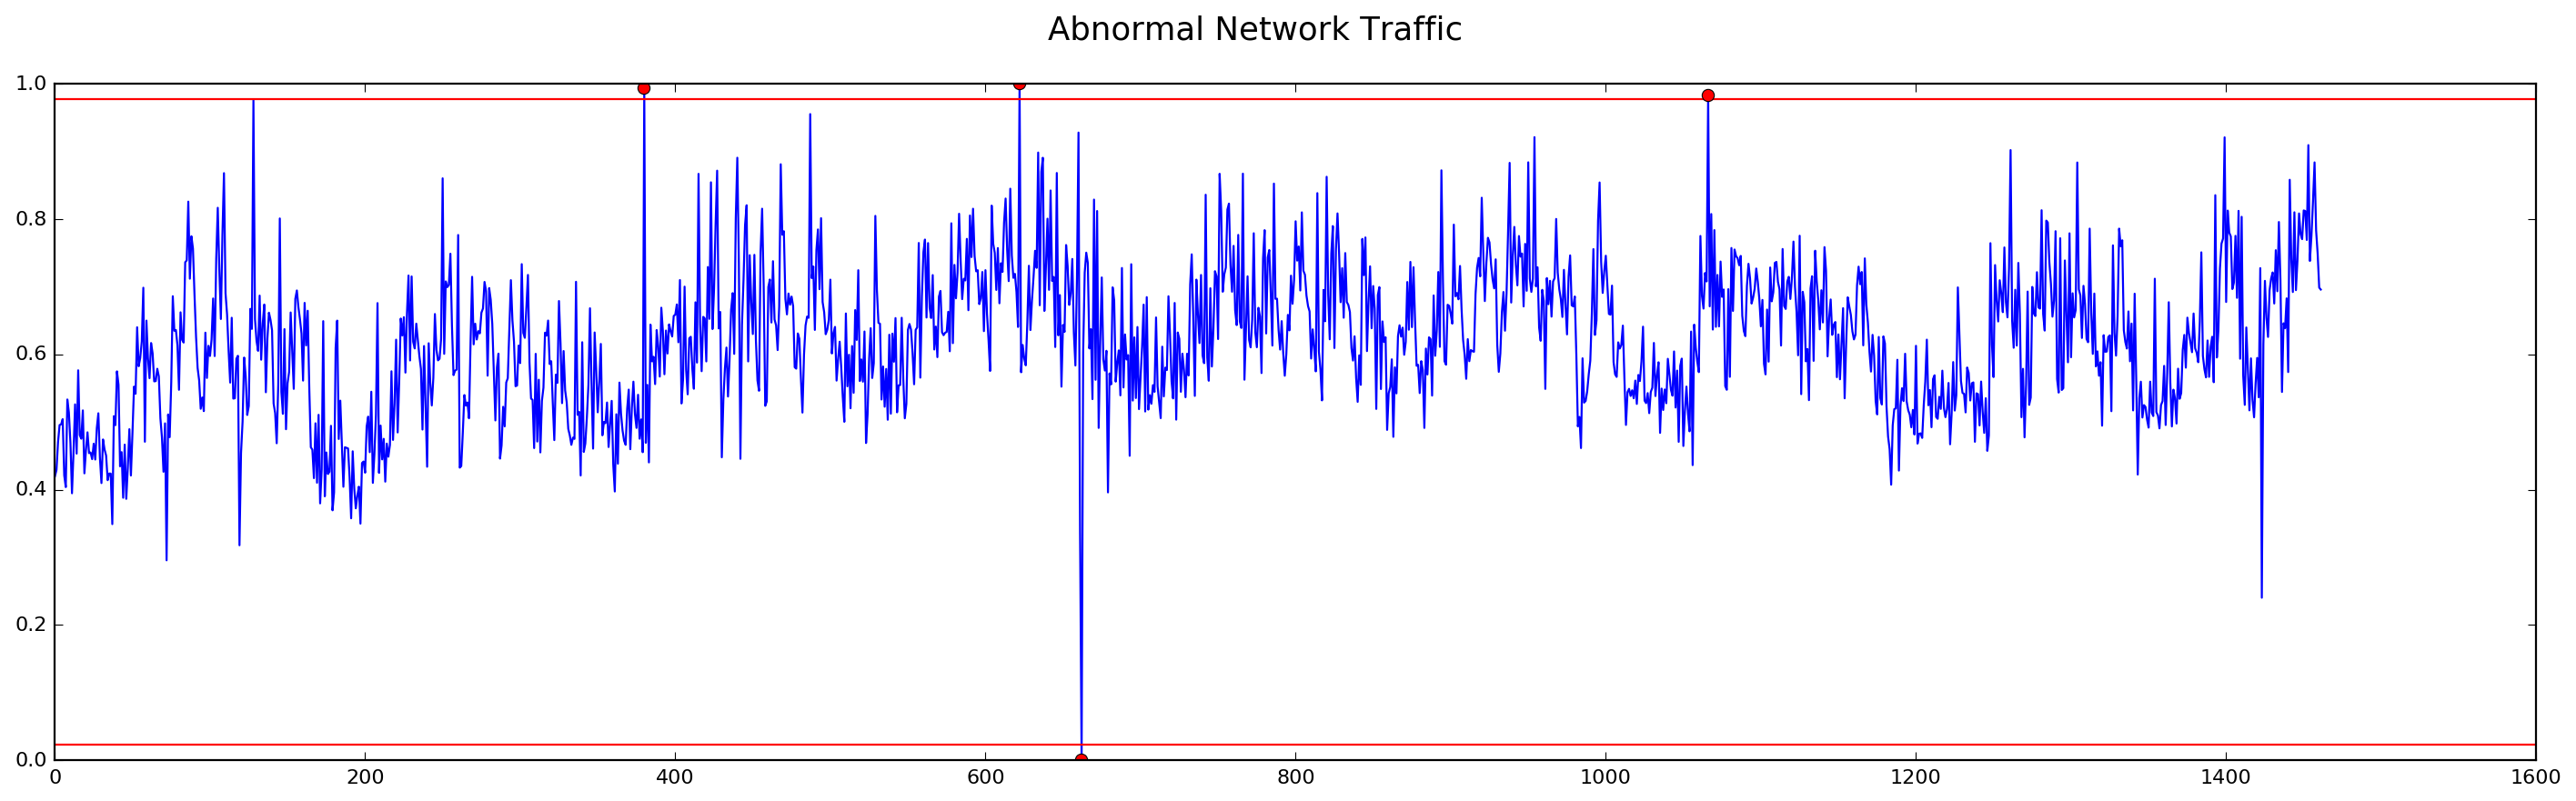

In [17]:
def find_outline_points(outline1, outline2, dataset):

    xaxis = pd.Series()
    yaxis = pd.Series()

    for i in range(len(dataset)):
        if dataset[i]<outline1 or dataset[i]>outline2:
            l = pd.Series([i]) 
            xaxis=xaxis.append(l)
            l2= pd.Series(dataset[i])
            yaxis=yaxis.append(l2)
            
    xaxis.reset_index(drop=True, inplace=True)
    yaxis.reset_index(drop=True, inplace=True)    
                         
    print(xaxis)
    print(yaxis)

    plt.figure(figsize=(22,6), dpi=80)
    plt.suptitle('Abnormal Network Traffic', fontsize=16) 
    plt.plot(dataset, color="blue")
    plt.axhline(y=outline1, color = "red")
    plt.axhline(y=outline2, color = "red")
    plt.plot(xaxis, yaxis, "ro", color = "red")
    plt.show()
    return xaxis, yaxis

dataset_receive_x, dataset_receive_y = find_outline_points(dataset_receive_outline1, dataset_receive_outline2, dataset_receive)
dataset_transfer_x, dataset_transfer_y = find_outline_points(dataset_transfer_outline1, dataset_transfer_outline2, dataset_transfer)



The following figures show that after adjusting the abnormal points, we now have all network data inside the outlier boundaries (occurrence rate of 95.46%). 

(662, array([ 0.6]))
(951, array([ 0.6847432]))
(1064, array([ 0.69988375]))
(1114, array([ 0.7]))
(1303, array([ 0.67969094]))


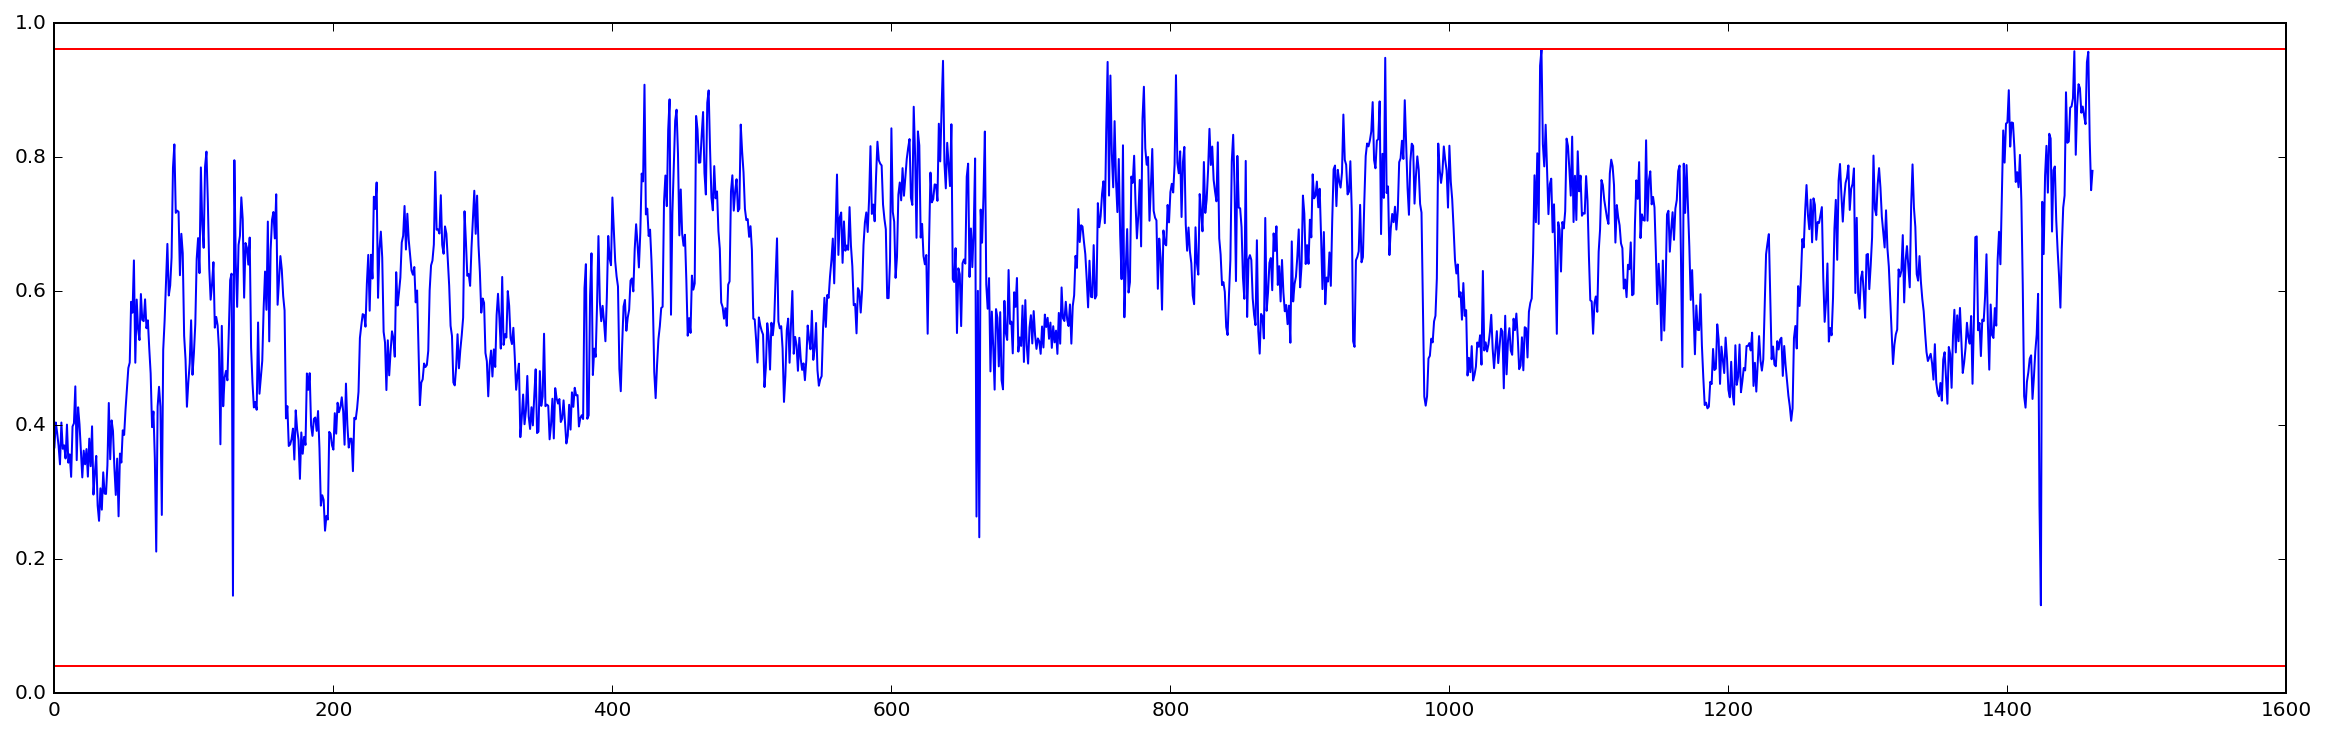

(380, array([ 0.6952966]))
(622, array([ 0.7]))
(662, array([ 0.6]))
(1066, array([ 0.68800959]))


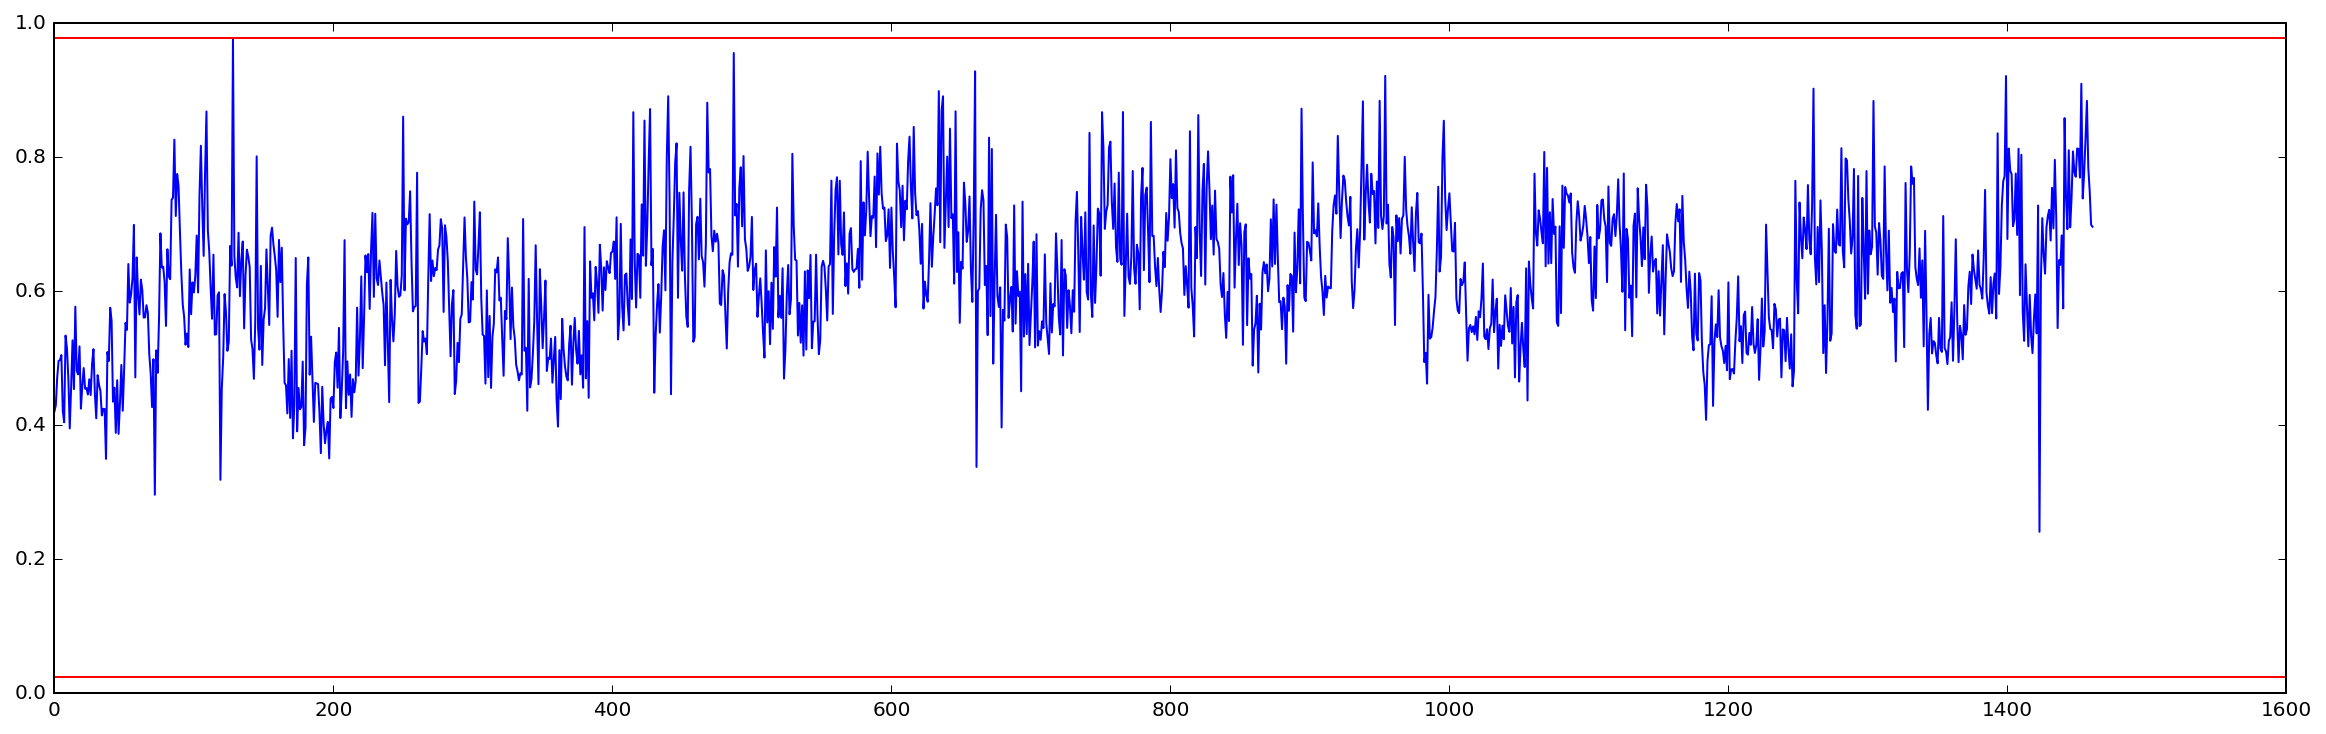

In [18]:
def remove_outliner(outline1, outline2, xaxis, yaxis, dataset):
    

    for i in range(len(xaxis)):
        a=xaxis[i].astype(int)
        if yaxis[i]==0:
            dataset[a]=0.6
        elif yaxis[i]>0.5:
            dataset[a]=dataset[a]*0.7
        elif yaxis[i]<0.5:
            dataset[a]=dataset[a]*1.3
        print(a, dataset[a])

    
    plt.figure(figsize=(20,6))
    plt.plot(dataset)
    plt.axhline(y=outline1, color = "red")
    plt.axhline(y=outline2, color = "red")
    plt.show()
    return dataset

dataset_receive= remove_outliner(dataset_receive_outline1, dataset_receive_outline2, dataset_receive_x, dataset_receive_y, dataset_receive)
dataset_transfer= remove_outliner(dataset_transfer_outline1, dataset_transfer_outline2, dataset_transfer_x, dataset_transfer_y, dataset_transfer)

## Build Multi-step LSTM Model

As we now have all datasets ready, we can start building the multi-step LSTM model. During model training and forecasting, each time step of the test dataset will be walked one at a time, and a multi-step forecast will be made to predict the network traffic of the next few hours.

We will build a model for network received and network transferred traffic respectively.

### Create Training and Testing Data

We will split the dataset into two parts: a training and a test set. We will build the LSTM model using the training dataset and make predictions on the test dataset. 

Argument *n_in* defines the number of lag observations, and since the model will input only one network data at a time, this should be set to 1. The *n_out* is the number of observations generated as output, i.e. the number of hours that we will forecast when making predictions.

In [19]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [20]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	supervised = series_to_supervised(series, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

### Build LSTM Model
We've built a 2 layer LSTM model with a dropout of 0.2. 

In [21]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True,return_sequences=True))
	model.add(Dense(y.shape[1]))
	model.add(Dropout(0.2))
	model.add(LSTM(168,return_sequences=False))
	model.add(Activation('linear'))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, nb_epoch=1, batch_size=n_batch, verbose=2, shuffle=False)
		model.reset_states()
	return model
 
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts
 
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

### Traing Model and Make Predictions

Now let's train the model with the training dataset and make predictions.

The number of sequence (*n_seq*) that we set is 5, which means that the model will forecast the network traffic of the next 5 hours with each new data input.

The number of neurons affects the learning capacity of the network. Generally, more neurons would be able to learn more structure from the problem at the cost of longer training time. More learning capacity also creates the problem of potentially overfitting the training data. Since the dataset presents unique pattern within a week period in the Data Analysis section, here we will set the neuron number (*n_neurons*) to 168 (=24*7 hours).

Note that the batch size must to set to 1 because the same batch size should be used for training and prediction, and we require predictions to be made at each time step of the test dataset. 

In [ ]:
# configure
n_lag = 1
n_seq = 5
n_test = int(len(dataset_receive)*0.33)
n_epochs = 800
n_batch = 1
n_neurons = 168



# prepare network received data
train_received, test_received = prepare_data(dataset_receive, n_test, n_lag, n_seq)
# fit model for network received data
model_received = fit_lstm(train_received, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts for network received data
forecasts_received = make_forecasts(model_received, n_batch, train_received, test_received, n_lag, n_seq)

Epoch 1/1
18s - loss: 0.0168
Epoch 1/1
15s - loss: 0.0123
Epoch 1/1
14s - loss: 0.0124
Epoch 1/1
14s - loss: 0.0125
Epoch 1/1
14s - loss: 0.0122
Epoch 1/1
14s - loss: 0.0129
Epoch 1/1
14s - loss: 0.0136
Epoch 1/1
14s - loss: 0.0137
Epoch 1/1
15s - loss: 0.0144
Epoch 1/1
14s - loss: 0.0137
Epoch 1/1
13s - loss: 0.0159
Epoch 1/1
14s - loss: 0.0147
Epoch 1/1
14s - loss: 0.0151
Epoch 1/1
14s - loss: 0.0163
Epoch 1/1
14s - loss: 0.0163
Epoch 1/1
14s - loss: 0.0160
Epoch 1/1
14s - loss: 0.0147
Epoch 1/1
14s - loss: 0.0136
Epoch 1/1
14s - loss: 0.0142
Epoch 1/1
14s - loss: 0.0152
Epoch 1/1
14s - loss: 0.0140
Epoch 1/1
14s - loss: 0.0129
Epoch 1/1
14s - loss: 0.0153
Epoch 1/1
13s - loss: 0.0159
Epoch 1/1
14s - loss: 0.0142
Epoch 1/1
14s - loss: 0.0141
Epoch 1/1
14s - loss: 0.0138
Epoch 1/1
14s - loss: 0.0134
Epoch 1/1
14s - loss: 0.0134
Epoch 1/1
14s - loss: 0.0133
Epoch 1/1
14s - loss: 0.0128
Epoch 1/1
14s - loss: 0.0147
Epoch 1/1
14s - loss: 0.0136
Epoch 1/1
14s - loss: 0.0134
Epoch 1/1
14s 

In [40]:
# prepare network transferred data
train_transferred, test_transferred = prepare_data(dataset_transfer, n_test, n_lag, n_seq)
# fit model for network transferred data
model_transferred = fit_lstm(train_transferred, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts for network transferred data
forecasts_transferred = make_forecasts(model_transferred, n_batch, train_transferred, test_transferred, n_lag, n_seq)

Epoch 1/1
8s - loss: 0.0158
Epoch 1/1
7s - loss: 0.0093
Epoch 1/1
7s - loss: 0.0090
Epoch 1/1
7s - loss: 0.0085
Epoch 1/1
7s - loss: 0.0083
Epoch 1/1
7s - loss: 0.0082
Epoch 1/1
7s - loss: 0.0083
Epoch 1/1
7s - loss: 0.0084
Epoch 1/1
7s - loss: 0.0085
Epoch 1/1
7s - loss: 0.0086
Epoch 1/1
7s - loss: 0.0088
Epoch 1/1
7s - loss: 0.0089
Epoch 1/1
7s - loss: 0.0090
Epoch 1/1
7s - loss: 0.0090
Epoch 1/1
7s - loss: 0.0090
Epoch 1/1
7s - loss: 0.0091
Epoch 1/1
7s - loss: 0.0092
Epoch 1/1
7s - loss: 0.0092
Epoch 1/1
7s - loss: 0.0093
Epoch 1/1
7s - loss: 0.0094
Epoch 1/1
7s - loss: 0.0095
Epoch 1/1
7s - loss: 0.0092
Epoch 1/1
7s - loss: 0.0094
Epoch 1/1
7s - loss: 0.0091
Epoch 1/1
7s - loss: 0.0088
Epoch 1/1
7s - loss: 0.0085
Epoch 1/1
7s - loss: 0.0083
Epoch 1/1
7s - loss: 0.0081
Epoch 1/1
7s - loss: 0.0080
Epoch 1/1
7s - loss: 0.0081
Epoch 1/1
7s - loss: 0.0080
Epoch 1/1
7s - loss: 0.0079
Epoch 1/1
7s - loss: 0.0079
Epoch 1/1
7s - loss: 0.0078
Epoch 1/1
7s - loss: 0.0079
Epoch 1/1
7s - loss:

### Model Evaluation

In [37]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq, title):
	print (title)
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
        
# evaluate forecasts
evaluate_forecasts(test_received, forecasts_received, n_lag, n_seq, "Model Evaluation for Network Received Traffic")
evaluate_forecasts(test_transferred, forecasts_transferred, n_lag, n_seq, "Model Evaluation for Network Transferred Traffic")


Model Evaluation:
t+1 RMSE: 0.092001
t+2 RMSE: 0.103533
t+3 RMSE: 0.110169
t+4 RMSE: 0.119479
t+5 RMSE: 0.124867
Model Evaluation:
t+1 RMSE: 0.124715
t+2 RMSE: 0.123868
t+3 RMSE: 0.123621
t+4 RMSE: 0.122690
t+5 RMSE: 0.122966


### Plot Forecast

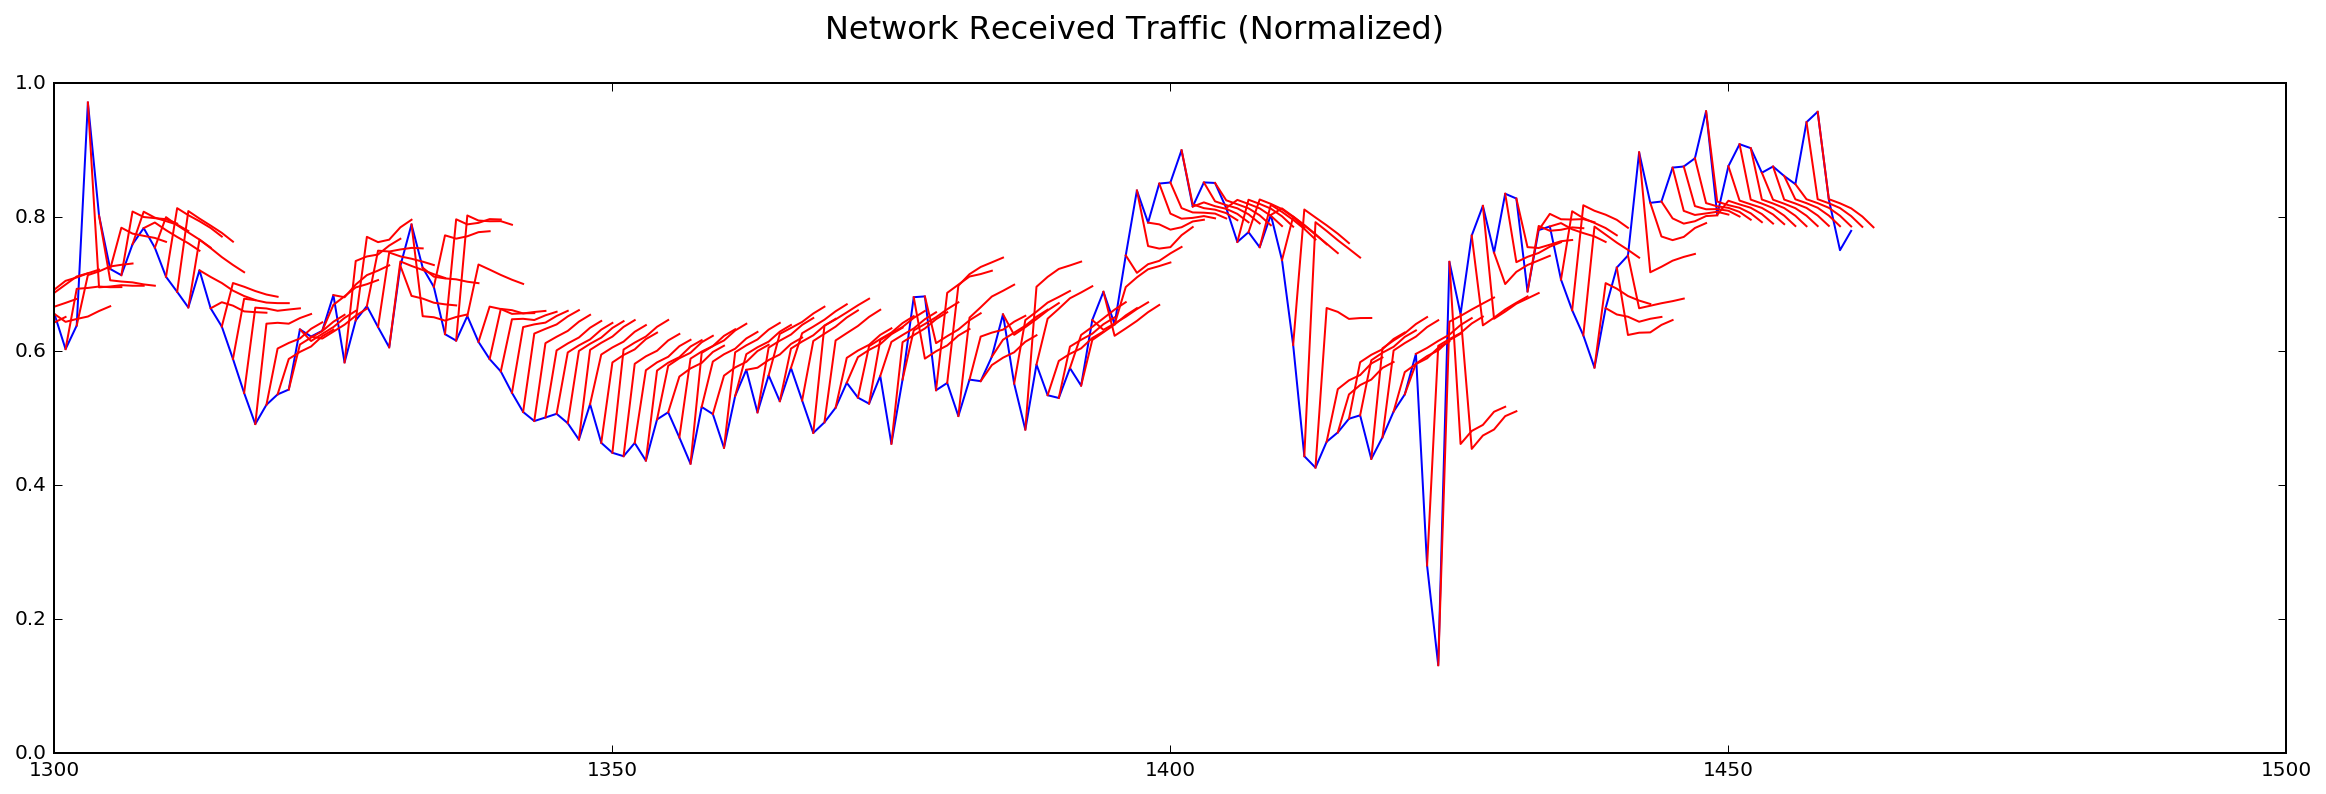

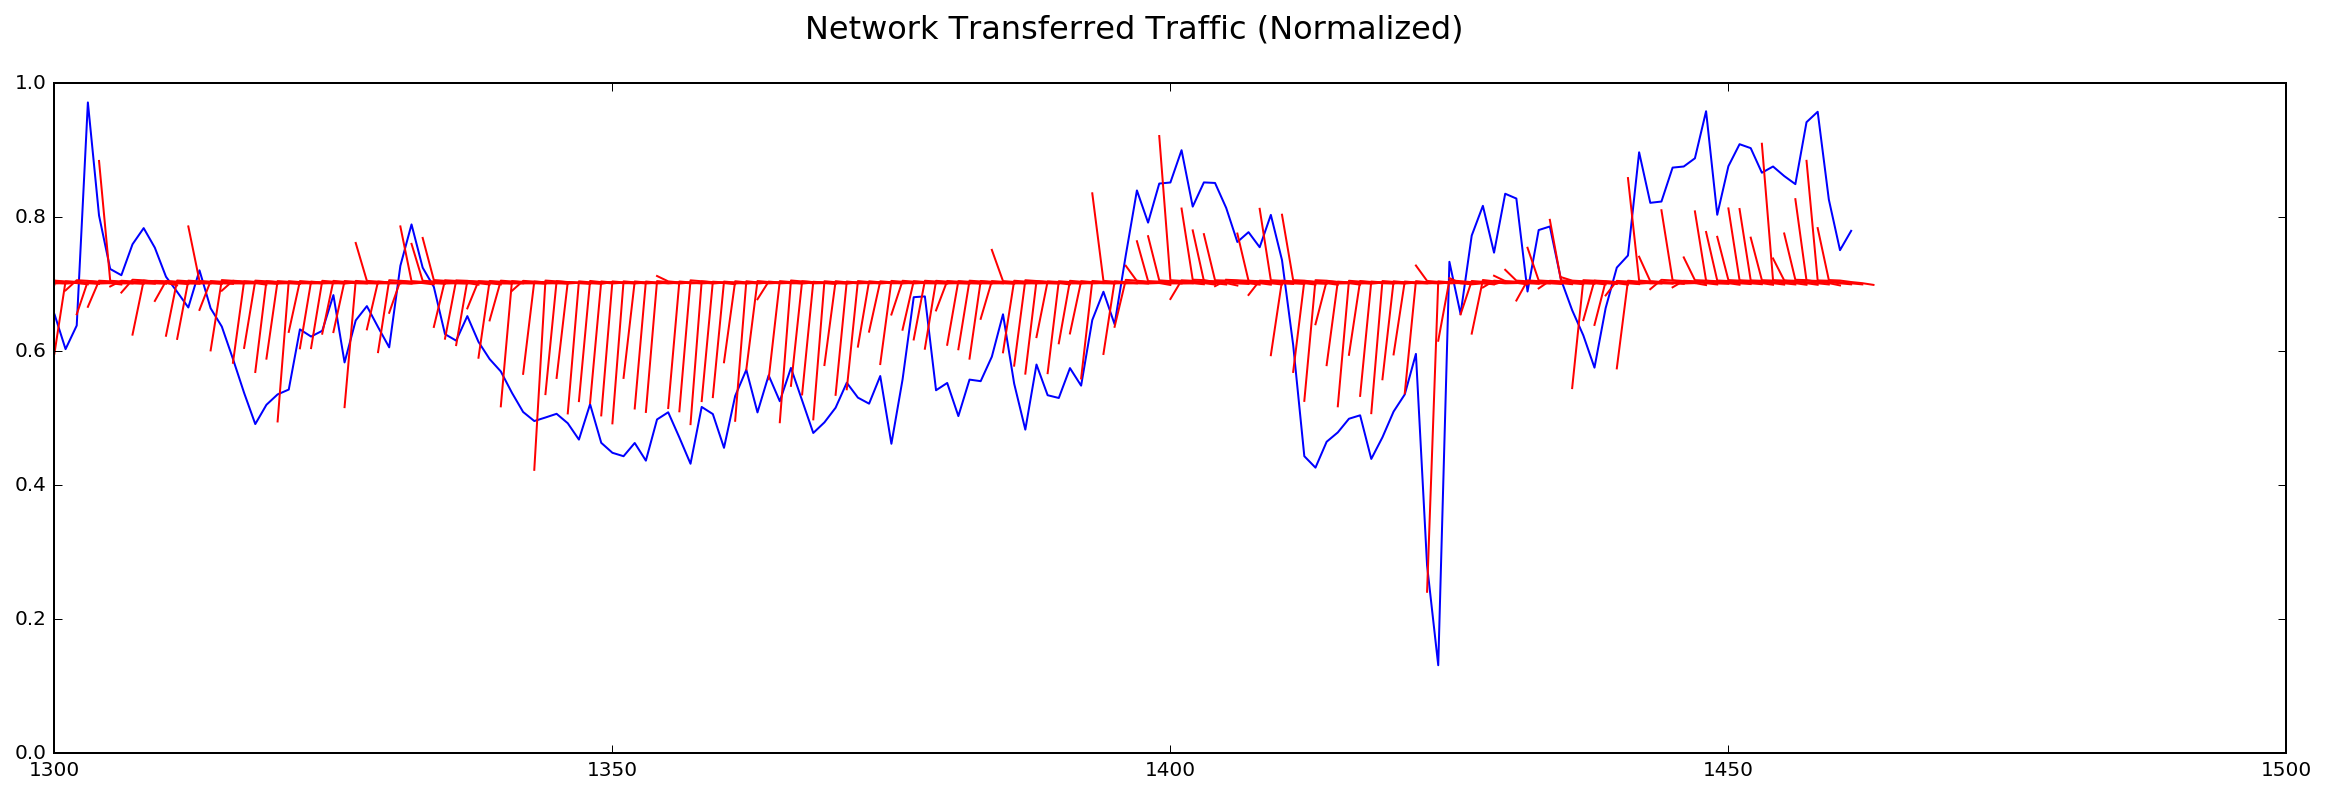

In [39]:
# plot forecasts with normalized data
def plot_forecasts_normalized(dataset, forecasts, n_test, title):
    plt.figure(figsize=(20,6))
    plt.xlim(1300,1500)
    plt.suptitle(title, fontsize=16) 
    # plot the entire dataset in blue
    plt.plot(dataset_receive)
    # plot the forecasts in red
    n_test=n_test+2
    for i in range(len(forecasts)):
        off_s = len(dataset) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [dataset[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()

plot_forecasts_normalized(dataset_receive, forecasts_received, n_test, "Network Received Traffic (Normalized)")
plot_forecasts_normalized(dataset_transfer, forecasts_transferred, n_test, "Network Transferred Traffic (Normalized)")

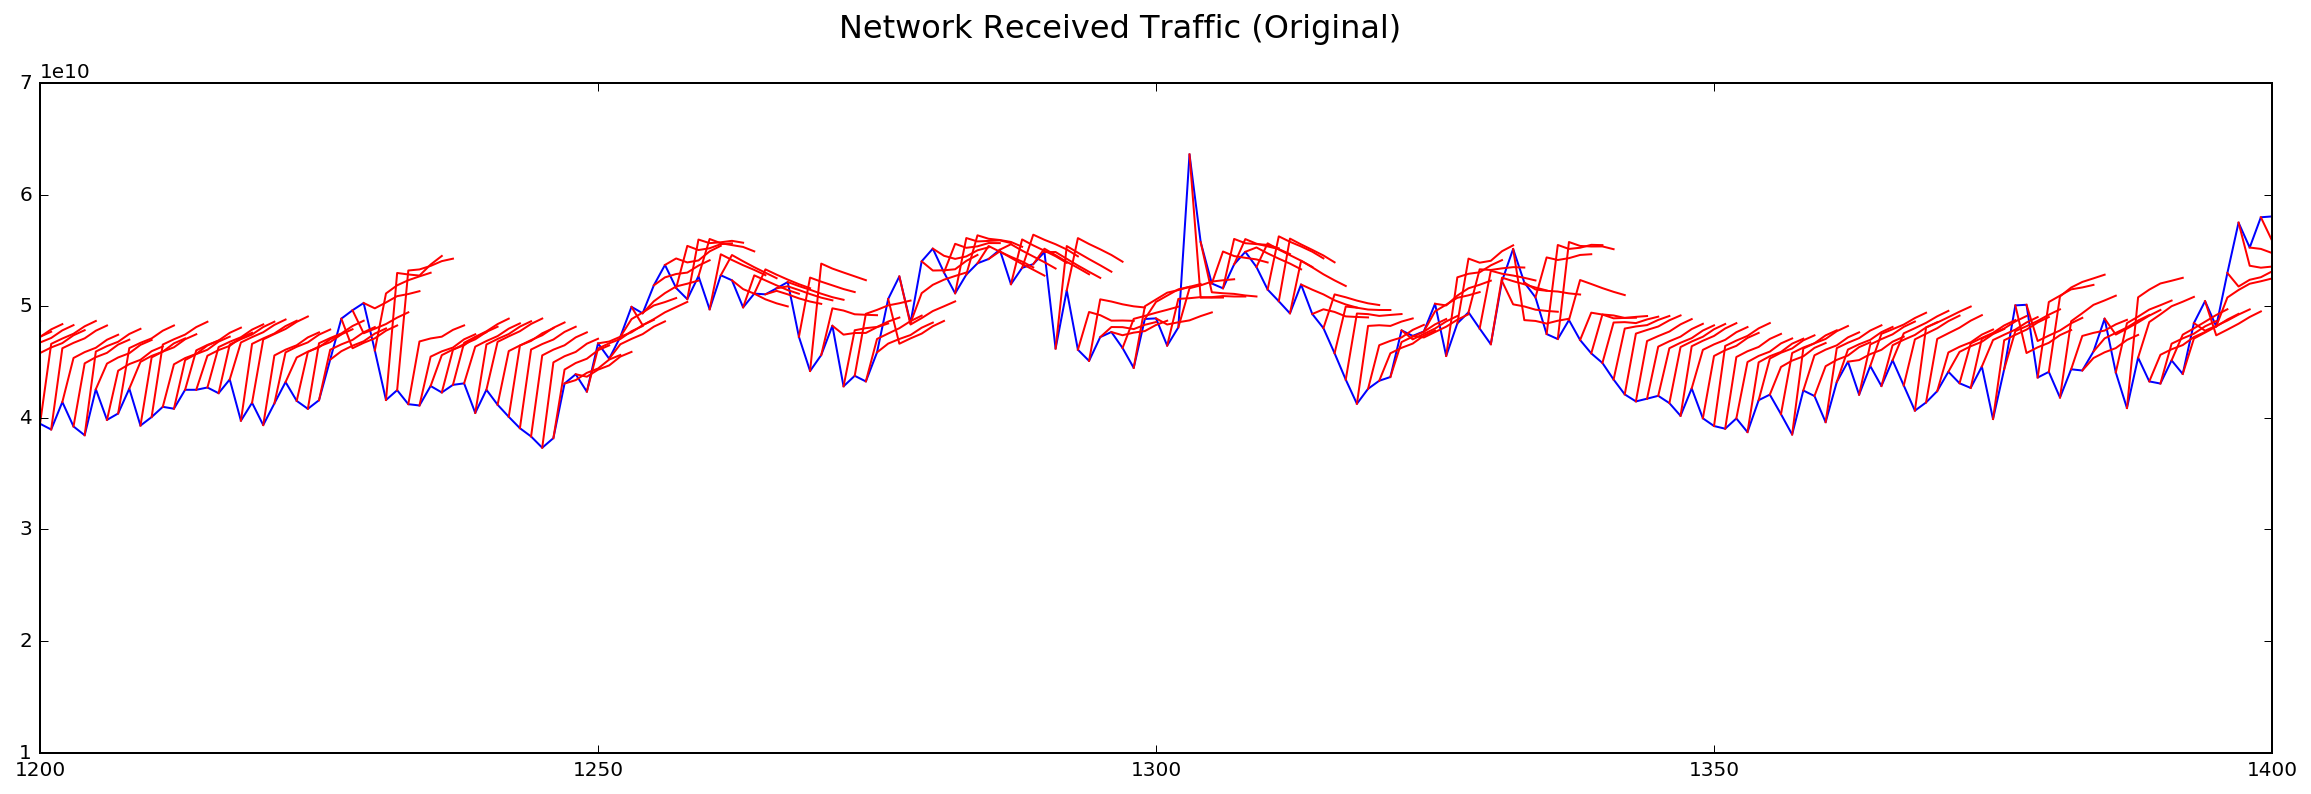

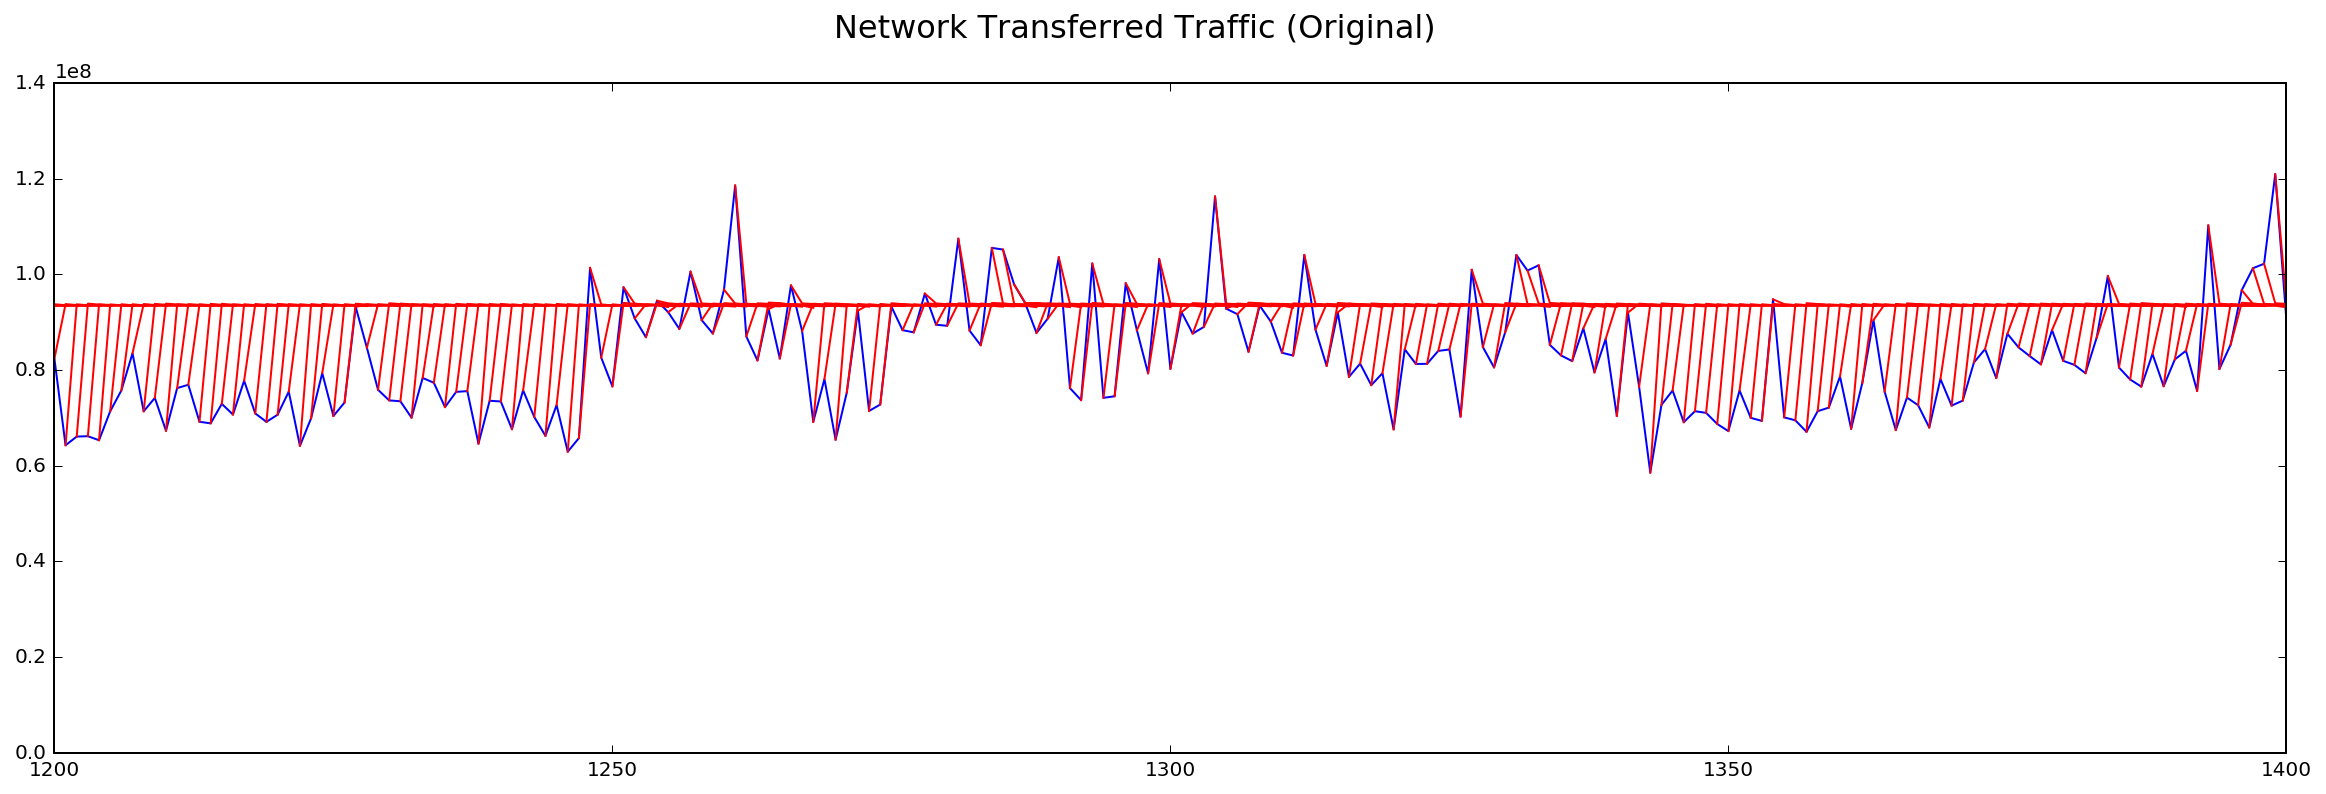

In [54]:
# plot the forecasts in the context of the original dataset
def plot_forecasts_original(dataset, forecasts, n_test, scaler, title):
    plt.figure(figsize=(20,6))
    plt.xlim(1200,1400)
    plt.suptitle(title, fontsize=16)
    # plot the entire dataset in blue
    data1=scaler.inverse_transform(dataset)
    forecasts_origin=scaler.inverse_transform(forecasts)
    plt.plot(data1)
    # plot the forecasts in red
    n_test=n_test+2
    
    for i in range(len(forecasts_origin)):
        off_s = len(dataset) - n_test + i - 1
        off_e = off_s + len(forecasts_origin[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        s1 = pd.Series([data1[off_s]])
        s2 = pd.Series(forecasts_origin[i])
        s3 = s1.append(s2)
        yaxis = np.asarray(s3) 
        plt.plot(xaxis, yaxis, color='red')

    # show the plot
    plt.show()

    
    
plot_forecasts_original(dataset_receive, forecasts_received, n_test, scaler, "Network Received Traffic (Original)")
plot_forecasts_original(dataset_transfer, forecasts_transferred, n_test, scaler2, "Network Transferred Traffic (Original)")


## Build One-step LSTM Model

Apart from predicting the next few hours of network traffic, there would also be cases when you want to forecast only the network data of the next hour based on all previous inputs. In such cases, the model will make a forecast for the next hour based on all previous network data. Then, the actual expected data for the next hour from the test dataset will be taken and made available to the model for the forecast on the next time step.

### Create Training and Testing Data
Making training mini-batches

In [22]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

Split data into training data and test data

In [23]:
def split_dataset(dataset, train_test_split=0.67,look_back=1):
    # split into train and test sets
    train_size = int(len(dataset) * train_test_split)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    return trainX,trainY,testX,testY

In [24]:
look_back=24
trainX,trainY,testX,testY=split_dataset(dataset_receive,look_back=look_back)
train_transferX, train_transferY, test_transferX, test_transferY=split_dataset(dataset_transfer,look_back=look_back)

### Build LSTM Model
In this section, 2 layer model will be created. First layer is lstm and second layer is fully connected layer.

In [25]:
def build_1step_lstm(look_back):
    # fix random seed for reproducibility
    np.random.seed(7)
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(output_dim=256, input_shape=(1, look_back),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(256,return_sequences=False))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

receive_1step_model=build_1step_lstm(look_back)
transfer_1step_model=build_1step_lstm(look_back)

### Train Model

In [31]:
epochs=4000
batch=100

receive_1step_model.fit(trainX, trainY, nb_epoch=epochs, batch_size=batch, verbose=2)

Epoch 1/4000
0s - loss: 0.0041
Epoch 2/4000
0s - loss: 0.0045
Epoch 3/4000
0s - loss: 0.0047
Epoch 4/4000
0s - loss: 0.0043
Epoch 5/4000
0s - loss: 0.0041
Epoch 6/4000
0s - loss: 0.0040
Epoch 7/4000
0s - loss: 0.0040
Epoch 8/4000
0s - loss: 0.0041
Epoch 9/4000
0s - loss: 0.0040
Epoch 10/4000
0s - loss: 0.0041
Epoch 11/4000
0s - loss: 0.0041
Epoch 12/4000
0s - loss: 0.0042
Epoch 13/4000
0s - loss: 0.0040
Epoch 14/4000
0s - loss: 0.0041
Epoch 15/4000
0s - loss: 0.0040
Epoch 16/4000
0s - loss: 0.0041
Epoch 17/4000
0s - loss: 0.0040
Epoch 18/4000
0s - loss: 0.0041
Epoch 19/4000
0s - loss: 0.0040
Epoch 20/4000
0s - loss: 0.0041
Epoch 21/4000
0s - loss: 0.0040
Epoch 22/4000
0s - loss: 0.0040
Epoch 23/4000
0s - loss: 0.0041
Epoch 24/4000
0s - loss: 0.0040
Epoch 25/4000
0s - loss: 0.0040
Epoch 26/4000
0s - loss: 0.0041
Epoch 27/4000
0s - loss: 0.0040
Epoch 28/4000
0s - loss: 0.0041
Epoch 29/4000
0s - loss: 0.0041
Epoch 30/4000
0s - loss: 0.0042
Epoch 31/4000
0s - loss: 0.0038
Epoch 32/4000
0s 

In [32]:
transfer_1step_model.fit(train_transferX, train_transferY, nb_epoch=epochs, batch_size=batch, verbose=2)

Epoch 1/4000
0s - loss: 0.0061
Epoch 2/4000
0s - loss: 0.0060
Epoch 3/4000
0s - loss: 0.0059
Epoch 4/4000
0s - loss: 0.0059
Epoch 5/4000
0s - loss: 0.0060
Epoch 6/4000
0s - loss: 0.0063
Epoch 7/4000
0s - loss: 0.0061
Epoch 8/4000
0s - loss: 0.0060
Epoch 9/4000
0s - loss: 0.0058
Epoch 10/4000
0s - loss: 0.0056
Epoch 11/4000
0s - loss: 0.0057
Epoch 12/4000
0s - loss: 0.0058
Epoch 13/4000
0s - loss: 0.0058
Epoch 14/4000
0s - loss: 0.0058
Epoch 15/4000
0s - loss: 0.0057
Epoch 16/4000
0s - loss: 0.0058
Epoch 17/4000
0s - loss: 0.0057
Epoch 18/4000
0s - loss: 0.0058
Epoch 19/4000
0s - loss: 0.0060
Epoch 20/4000
0s - loss: 0.0058
Epoch 21/4000
0s - loss: 0.0059
Epoch 22/4000
0s - loss: 0.0058
Epoch 23/4000
0s - loss: 0.0057
Epoch 24/4000
0s - loss: 0.0058
Epoch 25/4000
0s - loss: 0.0057
Epoch 26/4000
0s - loss: 0.0057
Epoch 27/4000
0s - loss: 0.0056
Epoch 28/4000
0s - loss: 0.0057
Epoch 29/4000
0s - loss: 0.0057
Epoch 30/4000
0s - loss: 0.0057
Epoch 31/4000
0s - loss: 0.0058
Epoch 32/4000
0s 

### Make Prediction and Evaluate

In [33]:
def predict_dataset(dataset, trainX, trainY ,testX, testY, scaler, model):
    # make predictions
    trainPredict1 = model.predict(trainX)
    testPredict1 = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict1)
    trainY_origin = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict1)
    testY_origin = scaler.inverse_transform([testY])
    
    print("Normalized Score:")
    trainScore1 = math.sqrt(mean_squared_error([trainY][0], trainPredict1[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore1))
    testScore1 = math.sqrt(mean_squared_error([testY][0], testPredict1[:,0]))
    print('Test Score: %.2f RMSE' % (testScore1))
    
    print("Original Score:")
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY_origin[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY_origin[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    return trainPredictPlot, testPredictPlot

In [34]:
# predict for received network dataset
trainPredictPlot_receive,testPredictPlot_receive=predict_dataset(dataset_receive, trainX, trainY ,testX, testY, scaler, receive_1step_model)

# predict for transferred network dataset
trainPredictPlot_transfer,testPredictPlot_transfer=predict_dataset(dataset_transfer, train_transferX, train_transferY ,test_transferX, test_transferY, scaler2, transfer_1step_model)

Normalized Score:
Train Score: 0.01 RMSE
Test Score: 0.08 RMSE
Original Score:
Train Score: 622856520.28 RMSE
Test Score: 3925317101.18 RMSE
Normalized Score:
Train Score: 0.01 RMSE
Test Score: 0.09 RMSE
Original Score:
Train Score: 1492546.85 RMSE
Test Score: 10845542.92 RMSE


### Plot Forecast

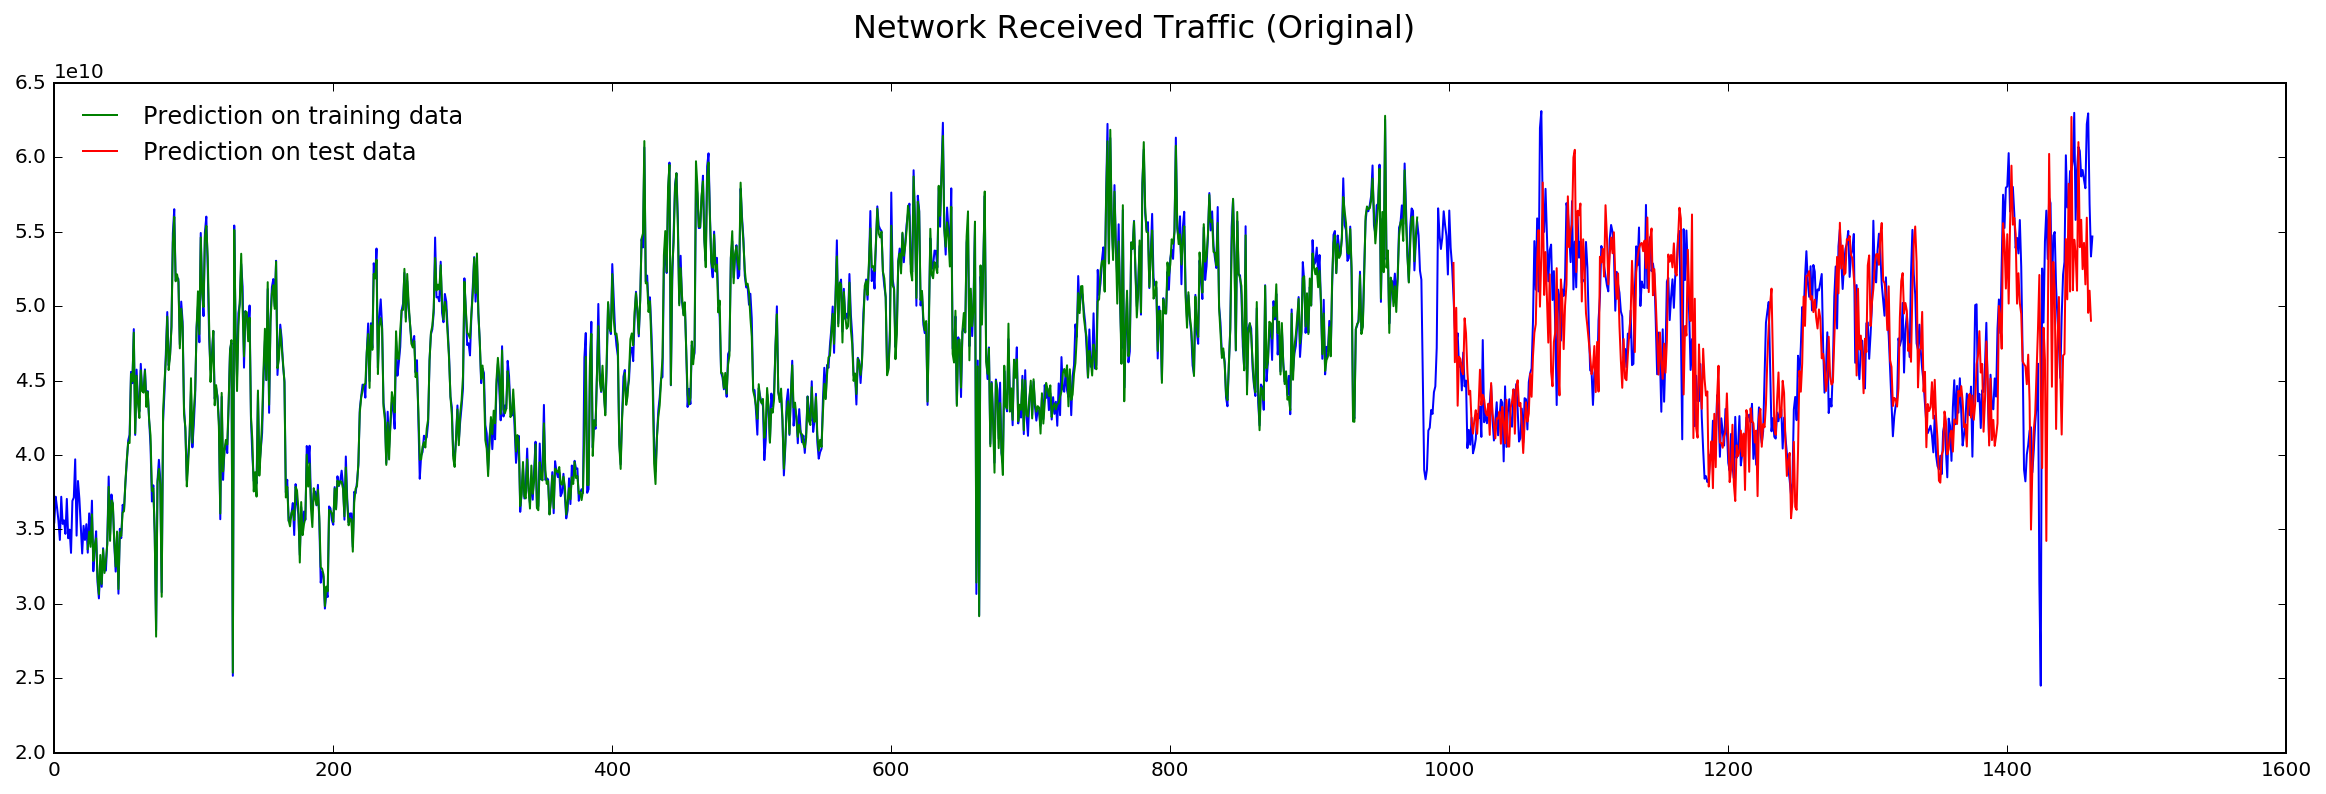

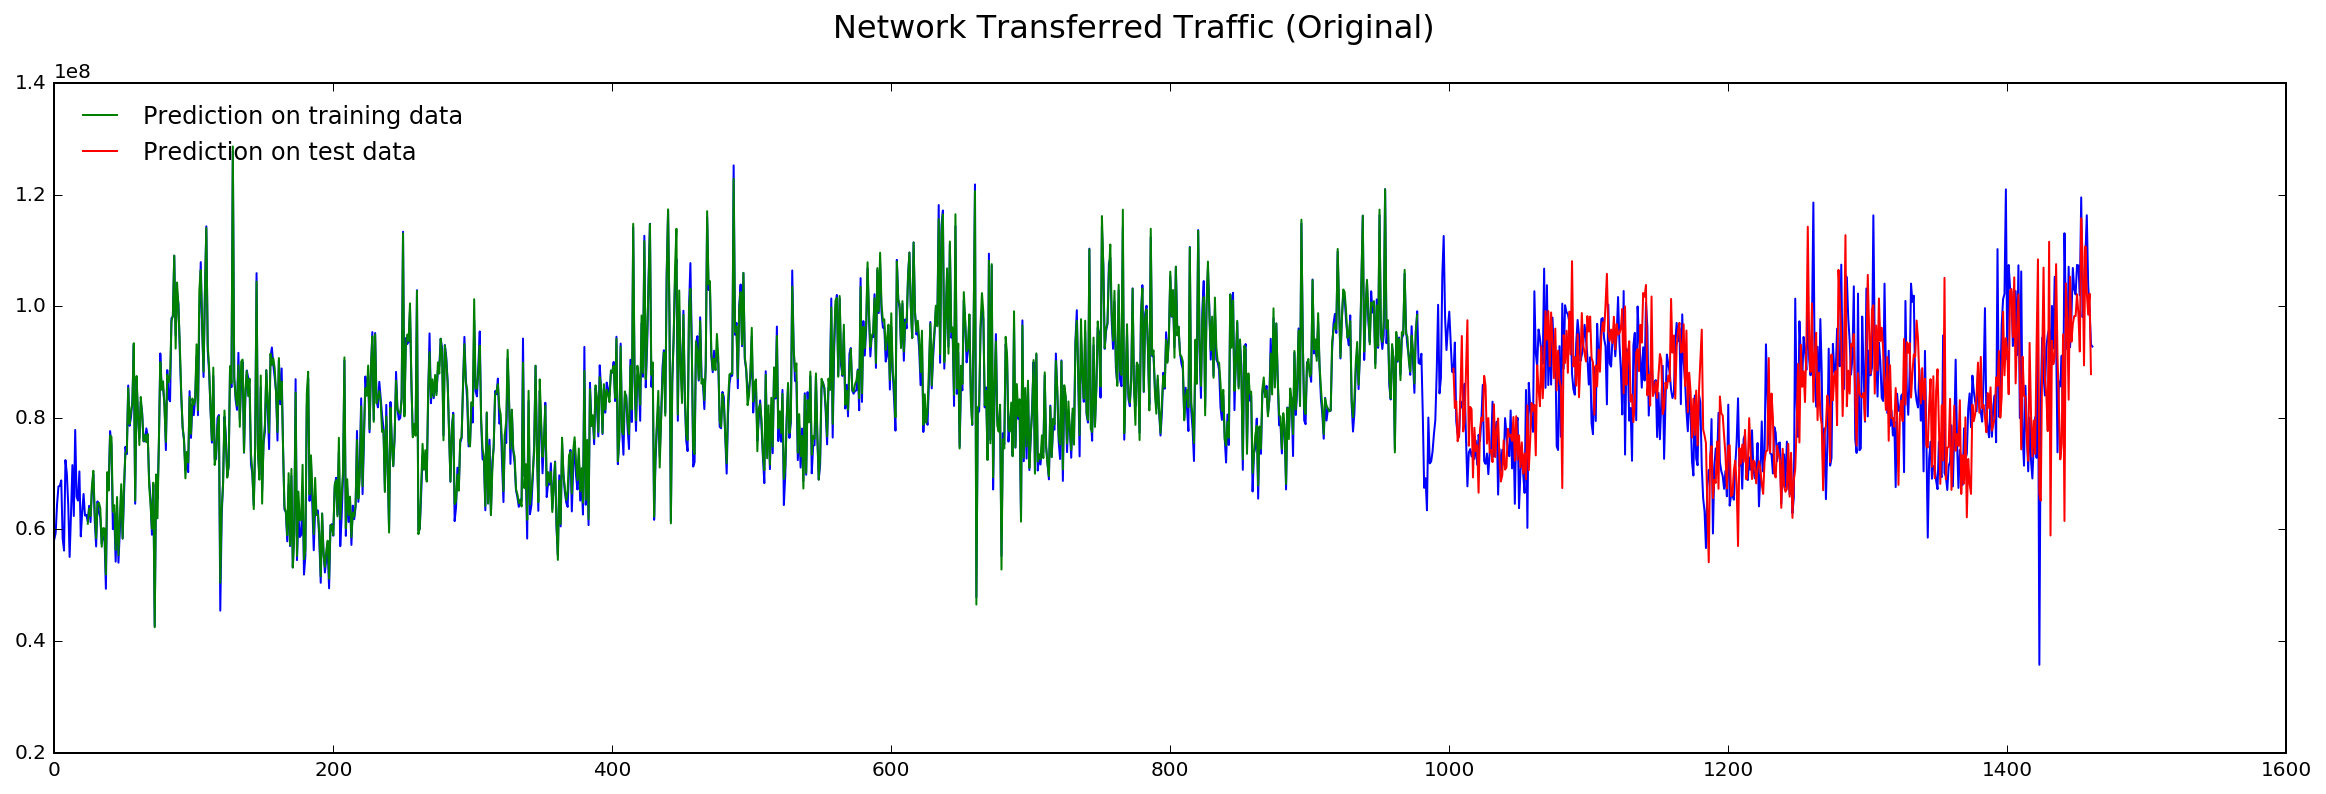

In [37]:
def plot_1step_forecase(dataset, trainPredictPlot, testPredictPlot, scaler, title):
    plt.figure(figsize=(20,6))
    plt.suptitle(title, fontsize=16)
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot, label="Prediction on training data")
    plt.plot(testPredictPlot, label="Prediction on test data")
    plt.legend(loc='upper left', frameon=False)
    plt.show()

# plot baseline and predictions for received traffic data
plot_1step_forecase(dataset_receive, trainPredictPlot_receive, testPredictPlot_receive, scaler, "Network Received Traffic (Original)")

# plot baseline and predictions for transferred traffic data
plot_1step_forecase(dataset_transfer, trainPredictPlot_transfer, testPredictPlot_transfer, scaler2, "Network Transferred Traffic (Original)")

# Save Model

In [45]:
!pip install h5py

    100% |████████████████████████████████| 4.4MB 283kB/s eta 0:00:01


In [52]:

model_file_1step_rev="model_file_1step_rev.h5"
model_file_1step_trasnfer="model_file_1step_transfer.h5"

model_file_mstep_rev="model_file_mstep_rev.h5"
model_file_mstep_transfer="model_file_mstep_transfer.h5"

transfer_1step_model.save(model_file_1step_trasnfer)
receive_1step_model.save(model_file_1step_rev)
model_transferred.save(model_file_mstep_transfer)
model_received.save(model_file_mstep_rev)

transfer_1step_model.save_weights('weights_'+model_file_1step_trasnfer)
receive_1step_model.save_weights('weights_'+model_file_1step_rev)
model_transferred.save_weights(model_file_mstep_transfer)
model_received.save_weights(model_file_mstep_rev)

In [53]:
!ls -al

total 9956184
drwx------  2 sffc-3691fbb0f320c6-8c20818cd6ff users       4096 Jul 21 00:25 .
drwx------ 11 sffc-3691fbb0f320c6-8c20818cd6ff users       4096 Jul 16 20:46 ..
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users 5922295808 Jul  4 04:54 core.38527
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users    9804432 Jul 21 00:25 model_file_1step_rev.model
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users    9804480 Jul 21 00:25 model_file_1step_transfer.model
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users    2842008 Jul 21 00:25 model_file_mstep_rev.model
-rw-------  1 sffc-3691fbb0f320c6-8c20818cd6ff users    2842008 Jul 21 00:25 model_file_mstep_transfer.model


# Load Model and run it in production

In [ ]:
from keras.models import load_mode
load_model(model_file_1step_rev)
model.load_weights('weights_'+model_file_1step_rev)


## Conclusion 

root-mean-square error (RMSE)

use normalized data value to compute RMSE - easiler to compare / adjusting values measured on different scales to a notionally common scale

one-step LSTM model shows better forcasting results, which is reasonable since it's easier to predict one time step than to predict 5.

compare evaluation
RMSE

plot diagram

data analysis & explanation